In [184]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [185]:
#Currently working with a small tracking cost. Will implement the cost to go constraint now. 

In [186]:
#Fixes to try: 
#1. Get discrete dynamics jacobians with RK4. Matrix exponential is only exact for LTI systems. (done)
#2. Implement the second order correction (done) (not needed, it was a bug with the reference trajectory)
#3. More conservative half space constraint (done)
#4. Change the c at each knot point according to the maximum delta x deviation possible

#4. Current orbit is not exactly periodic (xend - xinitial). Set the reference trajectory to that orbit revd twice instead of concatenating two arrays (potential fix)

In [187]:
#Current bug: reference_trajectory2 has to be updated in the half solve. Currently it is the wrong dynamics constraint since the reference trajectory is
# from the beginning.  

In [188]:
# #scaled dynamics in the user defined custom units  
# function threebp_dynamics_scaled(x, u)
    
#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]
    
#     if Lagrange_Point == "L1"
        
#         #L1 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [0.8369180073169304, 0,0,0,0,0]

#     else
        
#         #L2 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [1.1556799130947355,0,0,0,0,0]

#     end
    
#     #get it back to original units and without the L1 shift  
#     x_original_unshift = x_original+L
    
#     ẋ_original = zeros(eltype(x),6)
    
#     #calculate the original xdot (no scaling)
#     ẋ_original = threebp_dynamics(x_original_unshift, u)

#     #then scale these dynamics
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale
        
#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled
# end

In [189]:
#from the Lyaponov orbit
#x0_lyapunov = [ 1.1556814491008298,
# -1.4319993886822296e-21,
#  0.0,
#  2.2212106056655213e-21,
# -8.333136405918907e-6,
#  0.0]



 #lyapunov_period = 3.3732524857835884


In [190]:
# T_og = 2.361e6 #in seconds - orbital period of m1 and m2
# time_scale_og = T_og/(2*pi)

In [191]:
og_time_scale = 2.361e6/(2*pi)

375764.8206399649

In [192]:
#parameters for Earth Moon System
μ = 1.901109735892602e-7
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook (original)
L = 238529 #in km - distance between centers of m1 and m2
#V_ = 1.025 #in km/s - orbital velocity of m1
#T_ = 2.361e6 #in seconds - orbital period of m1 and m2


#working
#########################################################################################
#updated for time unit to be in days
T_ = 18913/86400 #in days - orbital period of m1 and m2
time_scale = T_/(2*pi)

#time unit of days
V_ = L/time_scale
acceleration_scale = L/((time_scale)^2)
##########################################################################################

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.99601828, 0, 0, 0, 0, 0]
XL2 = [1.00399194, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.00399194
 0.0
 0.0
 0.0
 0.0
 0.0

In [193]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [194]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [195]:
#x[1:6] -> state
#x[7:9] -> control inputs

#coming in with SI units
function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [196]:
#this just scales the dynamics by L and V_

In [197]:
#inputs are in the custom SI unit scale

function three_body_prob_dynamics_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    
    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = three_body_prob_dynamics(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_scaled (generic function with 1 method)

In [198]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = x[7:9]/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled; u_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled (generic function with 1 method)

In [202]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    #original CR3BP units
    #du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])

    #scaled units
    du[1:9] = three_body_prob_dynamics_wcontrol_scaled(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [203]:
#ensure that the x_0 coming in and the period are in scaled units

function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [204]:
#input is the initial condition
#control trajectory u (size N-1)

#integrate every half orbit

#u is size 20

#40 knot points in one rev. each of them are equally spaced apart


#ensure everything is in scaled units
function integrate_halfperiod(x_0, u)
    
    #u will be size 20
    
    #x trajectory not delta x 

    xtraj = zeros(6, 21)

    xtraj[:,1] = x_0

    #go through all the controls
    for i=1:20
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        #has the scaling included
        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
        
    end
    
    #this is size N. 21. Element 21 is the new 1
    return xtraj
        
end

integrate_halfperiod (generic function with 1 method)

In [205]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)
        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [206]:
#ODE for the state transition matrix 

function phi_ode(z)
    
    #state vector
    x = z[1:6]
    
    #state transition matrix
    Φ = reshape(z[7:end], (6,6))
    
    #Find the dynamics jacobian at the state vector (CR3BP dynamics)
    #F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics(dx), x)

    #scaled dynamics
    F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics_scaled(dx), x)
    
    #Differential Equation of State transition Matrix
    Φ_dot = F*Φ
    
    return vec(Φ_dot)
    
end

phi_ode (generic function with 1 method)

In [207]:
#3BP dynamics and state transition matrix dynamics in one function 
function ST_and_dynamics(z)
    x = z[1:6]
    Φ = z[7:end]
    
    x_dot = three_body_prob_dynamics_scaled(x)
    Φ_dot = phi_ode(z)
    
    z_dot = [x_dot; Φ_dot]
    
    return z_dot
end

ST_and_dynamics (generic function with 1 method)

In [208]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    du[7:end] = phi_ode(u)
    
end

ST_and_dynamics_DFJL! (generic function with 1 method)

In [209]:
#solve using DifferentialEquations.jl
function justdynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    
end

justdynamics_DFJL! (generic function with 1 method)

In [210]:
#gets the state and state transition matrix for the entire solution

function get_state_stm(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    all_stm = zeros(6,6,N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
        all_stm[:,:,i] = reshape(solution.u[i][7:end], (6,6)) 
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states, all_stm, solution.t 
end

get_state_stm (generic function with 1 method)

In [211]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [212]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [213]:

#this solved until we cross the xz plane
function diff_solve(x_0, period)
    
    #stop when y=0
    condition(u,t,integrator) = u[2]
    
    affect!(integrator) = terminate!(integrator)
    
    cb = ContinuousCallback(condition, affect!)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol = 1e-12, reltol=1e-12, callback=cb)
    
    return sol
    
end

diff_solve (generic function with 1 method)

In [215]:
#integrate dynamics and state transition matrix
function dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_integrate (generic function with 1 method)

In [216]:
#integrate just the dynamics
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(justdynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [217]:
T_ 

0.21890046296296295

In [218]:
time_scale 

0.03483909072565991

In [219]:
using DelimitedFiles
#period of the halo orbit. From ThreeBodyProblem.jl (in CR3BP units)
T = 3.0845904342589412

#period in custom units
T_scaled = T*time_scale

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
#richardson  = readdlm("richardsonL2.txt", '\t', Float64, '\n')'

#from the JPL software
x0_L2 = [1.0044381498075317E+0, 1.2098219477515610E-20, 9.4818006543268788E-4,
         -8.6884062363140839E-16, -3.8588161611699148E-3, -8.9659418958023516E-16]

x0_L2_scaled = [x0_L2[1:3]*L; x0_L2[4:6]*V_]

#for lyaponov
#x0_L2 = x0_lyapunov

#T = lyapunov_period

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -5.94859626923431e-9
 -26419.73544475346
     -6.138613580085994e-9

In [220]:
#linearize the dynamics about the L2 Lagrange Point and go in the planar direction
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), XL2)

In [221]:
#nonzero_cmplx_eigen_L2 = cmplx_eigen_L2[cmplx_eigen_L2 .!=0]

In [222]:
#marginally stable directions (periodic motion)
#direction2_L2 = A_L2_eigen.vectors[:, 2]
#direction3_L2 = A_L2_eigen.vectors[:, 3]
#direction4_L2 = A_L2_eigen.vectors[:, 4]
#direction5_L2 = A_L2_eigen.vectors[:, 5]

In [223]:
#display(direction2_L2)
#display(direction3_L2)
#display(direction4_L2)
#display(direction5_L2)
#directions 2 and 3 correspond to out of plane motion. We will select a perturbation
#in plane to get a Lyaponov orbit

In [224]:
#nonzero_cmplx_eigen_L2

In [225]:
#real(direction2_L2)

In [226]:
#real(direction3_L2)

In [227]:
#real(direction4_L2)

In [228]:
#real(direction5_L2)

In [ ]:
#we will perturb the L2 lagrange point by direction 5 (planar stable direction)
#approximate the period of Lyaponov orbit with T = |omega|/(2π) where omega = |λ_5|

#λ_planar = norm(A_L2_eigen.values[5])
#T_planar = 2*pi/λ_planar

#set T to whatever direction you use
#T = T_planar

#weight of the perturbation (1e-3 works)
#w2 = 1e-5

#this is the perturbation in the planar direction
#perturbation_planar_L2 = w2*(real(direction5_L2))

#this is a linear combination between both of the directions
#x0_L2 = XL2 + perturbation_planar_L2

In [230]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_final = dynamics_integrate(x_0_stm, T_scaled)

all_state_final, stm_final, sol_t_final = get_state_stm(solution_in)

([239587.62743544072 239587.62743348556 … 239587.31467884418 239587.62743536415; 2.885776193752321e-15 -0.06312017356234166 … 25.23811800220146 2.501107314628918e-8; … ; -26419.73544475346 -26419.735207000682 … -26381.69853509475 -26419.735442449262; -6.138613580085994e-9 -1.3446442905795948 … 537.7221721897366 -8.123025534991029e-7], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000159293465 -4.904570312687886e-13 … 1.6383724254305126e-10 2.33931655307807e-15; -1.0015144263953602e-12 0.9999999952492692 … 2.3891296559661358e-6 -1.4979266363842686e-19; … ; -1.2575890383439795e-6 -0.003976955154626066 … 0.9999999858439007 -2.5079034513683386e-13; 0.0024590128797433207 -7.314235635532228e-8 … 1.779491410490773e-14 0.9999999935240685;;; 1.0000000482107467 -2.5823779973990475e-12 … 4.958593738703919e-10 1.2317082210035562e-14; -5.2732220444540605e-12 0.9999999856217405 … 4.156355291446125e-6 -1.3720891805776236e-18; … ; -3.8061389901282315e-6 -0.00

In [231]:
#stm_in[:,:,210]

In [232]:
#a = LinRange(1,2,10)

In [233]:
#solution_in(a).u[2]

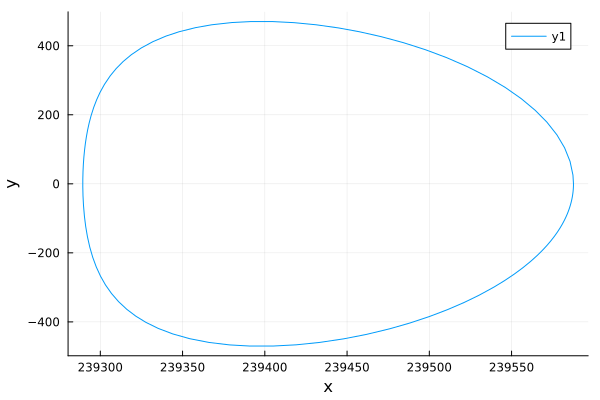

In [234]:
#this is if we rollout our dynamics with the stable initial condition
#almost periodic, can be fixed with a differential corrector
#plot(all_state_in[1,:], all_state_in[2,:], all_state_in[3,:], xlabel="x", ylabel="y", zlabel="z")

plot(all_state_final[1,:], all_state_final[2,:], xlabel="x", ylabel="y")

In [235]:
# #fix with a single shooting differential corrector
# function differential_corrector(x_0_stm, Tp)
    
#     #this is the final time it converges to
#     T_f = 0

#     #Iterate to bring the δx at T/2 to the desired state
#     max_iters = 1000

#     #keep z0 fixed and change only x0 and y_dot_0
#     for i=1:max_iters
#     #for i=1:100

#         solution = diff_solve(x_0_stm, Tp)

#         #this is the state, STM, and time when y crosses the XZ plane 
#         all_state, stm, sol_t = get_state_stm(solution)

#         #display(stm)

#         T2_state = all_state[:,end]

#         #T2_state -> x,y,z, xdot, ydot, zdot
#         #desired xdot an xzdot
#         xz_d = [0, 0]

#         rv = T2_state[1:6]

#         rv_dot = three_body_prob_dynamics_scaled(rv)

#         #desired state subtracted by state at t/2
#         δxz = xz_d - [T2_state[4], T2_state[6]]

#         #subset of the state transition matrix

#         #all 6 variables 
#         #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

#         #to change x and ydot 

#         #keep z0 constant
#         #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
#         #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

#         #keep x0 constant
#         stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
#         dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


#         #println("this is stm s: ")
#         #println(stm_s)


#         #keep y0 constant
#         #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
#         #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]

#         delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        
#         #println("THIS IS CONDITION NUMBER")
#         #println(cond((stm_s - dy/rv_dot[2])))

#         #delta_x0 = stm_s\δxz

#         #update the initial state

#         #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
#         x_0_stm[3] = x_0_stm[3] + delta_x0[1]
#         x_0_stm[5] = x_0_stm[5] + delta_x0[2]

#         #x_0_stm[1:6] = x_0_stm[1:6] + delta
#         #when delta is below a set tolerance we are done

#         println("residual: ", δxz)
        
#         #loosen up the tolerance bc of the scaling of the problem
#         if norm(δxz) < 1e-6

#             #this is the total time, but we use it to ensure we have enough time to find where
#             #y crosses the xz plane
#             #print("this is sol t: ", sol_t)
#             #updating time
                    
#             T_f = sol_t[end]*2
#             break
#         end

#     end
    
#     corrected_solution = dynamics_integrate(x_0_stm, T_f)

#     all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
#     return all_state_final, stm_final, sol_t_final, corrected_solution
    
# end

In [236]:
#run the differential corrector to get the corrected solution
# all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(x_0_stm, T_scaled)

In [237]:
# all_state_final

In [238]:
# sol_t_final

In [239]:
# sol_t_final[end]/time_scale

In [240]:
# all_state_final[1:3,1]/L 

In [241]:
# all_state_final[4:6]/V_

In [242]:
#Finding the unstable direction for the unstable manifold to encode as a constraint

#monodromy = stm_final[:,:,end]

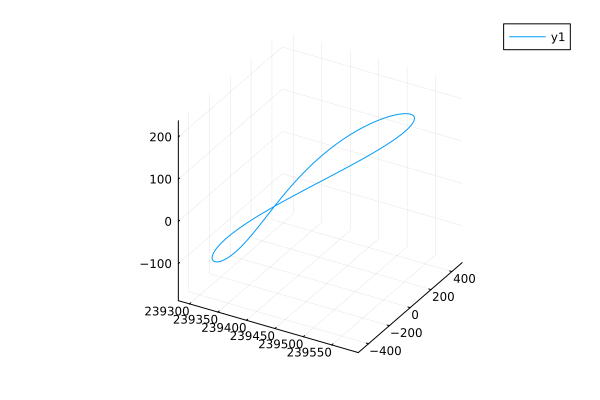

In [243]:
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [244]:
#using DelimitedFiles
#writedlm("xtraj.txt", all_state_final)

In [245]:
final_norm = all_state_final[:,end] - all_state_final[:,1]

6-element Vector{Float64}:
 -7.657217793166637e-8
  2.5011070260512984e-8
 -5.089333399155294e-9
 -4.817042959041947e-6
  2.3041975509840995e-6
 -8.061639399190169e-7

In [246]:
#create a 2 orbit horizon reference trajectory
periodic_initial_condition2 = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic2 = [periodic_initial_condition2; Φ_0]

#integrate for 2 revs
solution_periodic2 = dynamics_integrate(x_0_periodic2, 2*sol_t_final[end])

all_state_2, stm_in_2, sol_t_in_2 = get_state_stm(solution_periodic2)

([239587.62743544072 239587.62743348556 … 239587.46046480173 239587.6273222853; 2.885776193752321e-15 -0.06312017356234166 … 18.437032699790656 3.6617208512476916e-5; … ; -26419.73544475346 -26419.735207000682 … -26399.440003732878 -26419.732044665205; -6.138613580085994e-9 -1.3446442905795948 … 392.79064787080716 -0.001191095768596514], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000159293465 -4.904570312687886e-13 … 1.6383724254305126e-10 2.33931655307807e-15; -1.0015144263953602e-12 0.9999999952492692 … 2.3891296559661358e-6 -1.4979266363842686e-19; … ; -1.2575890383439795e-6 -0.003976955154626066 … 0.9999999858439007 -2.5079034513683386e-13; 0.0024590128797433207 -7.314235635532228e-8 … 1.779491410490773e-14 0.9999999935240685;;; 1.0000000482107467 -2.5823779973990475e-12 … 4.958593738703919e-10 1.2317082210035562e-14; -5.2732220444540605e-12 0.9999999856217405 … 4.156355291446125e-6 -1.3720891805776236e-18; … ; -3.8061389901282315e-6 -0

In [247]:
#Check when the orbit leave
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(x_0_stm, 4*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([239587.62743544072 239587.62743348556 … 239324.85241372712 239319.94062322896; 2.885776193752321e-15 -0.06312017356234166 … 78.23425758960362 73.06742907010666; … ; -26419.73544475346 -26419.735207000682 … -19605.147510190858 -19399.490447240587; -6.138613580085994e-9 -1.3446442905795948 … -3357.838258399564 -3608.2889057529933], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000159293465 -4.904570312687886e-13 … 1.6383724254305126e-10 2.33931655307807e-15; -1.0015144263953602e-12 0.9999999952492692 … 2.3891296559661358e-6 -1.4979266363842686e-19; … ; -1.2575890383439795e-6 -0.003976955154626066 … 0.9999999858439007 -2.5079034513683386e-13; 0.0024590128797433207 -7.314235635532228e-8 … 1.779491410490773e-14 0.9999999935240685;;; 1.0000000482107467 -2.5823779973990475e-12 … 4.958593738703919e-10 1.2317082210035562e-14; -5.2732220444540605e-12 0.9999999856217405 … 4.156355291446125e-6 -1.3720891805776236e-18; … ; -3.8061389901282315e-6 -0.00691

In [248]:
all_state_lp

6×441 Matrix{Float64}:
      2.39588e5         2.39588e5  …       2.39325e5       2.3932e5
      2.88578e-15      -0.0631202         78.2343         73.0674
    226.168           226.168            204.542         203.619
     -5.9486e-9        -1.63672       -18251.1        -18832.1
 -26419.7          -26419.7           -19605.1        -19399.5
     -6.13861e-9       -1.34464    …   -3357.84        -3608.29

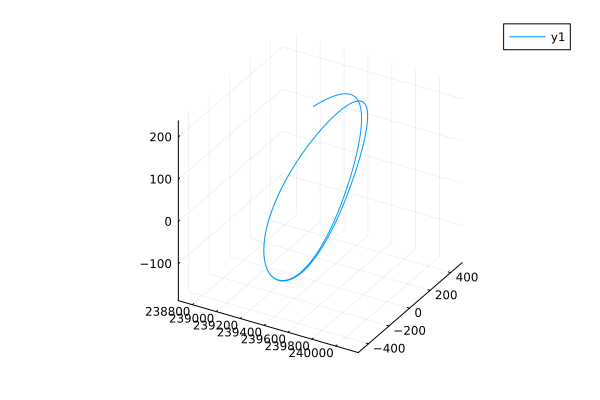

In [249]:
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

In [250]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [251]:
#this is the continuous dynamics
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), all_state_final[:,1])

In [252]:
#this is including the slack variable in the control vector
#B = [zeros(3,4); I][1:6, :]

In [253]:
nx = 6 #number of states
nu = 3 #number of controls 

3

In [254]:
sol_t_final[end ]

0.10746432599064995

In [258]:
#this is the A tilde to get the discretized dynamics
#Ã = [AL2 B; zeros(4,10)]

#this is the number of knot points in one horizon
N_period = 41  #40 knot points per period per period

#N_h = 82 #horizon 2 periods

N_h = 81 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.002686608149766249

In [259]:
sol_t_final[end]/time_scale

3.084590434258941

In [260]:
all_state_final[:,1]

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -5.94859626923431e-9
 -26419.73544475346
     -6.138613580085994e-9

In [262]:
# custom_position_scale = norm(all_state_final[:,1])
# custom_time_scale = sol_t_final[end]
# custom_velocity_scale = custom_position_scale/custom_time_scale

In [263]:
# function get_reference(i,N)
    
#     reference = zeros(nx, N)

#     for k=1:N

#         reference[:,k] = full_solution(horizon[i:end]).u[k][1:6]
        
#     end

#     return reference
    
# end

In [264]:
#Ad = H[1:nx, 1:nx]
#Bd = H[1:nx, nx+1:end]

In [265]:
#umin = 0.5
#umax = 1

In [266]:
#N (number of knot points) 6x6 discrete dynamics jacobians

#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [267]:
T_corrected = sol_t_final[end]

0.10746432599064995

In [268]:
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.00268661, 0.00537322, 0.00805982, …, 0.102091, 0.104778, 0.107464

In [269]:
horizon[2]

0.002686608149766249

In [270]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [271]:
horizon

41-element LinRange{Float64, Int64}:
 0.0, 0.00268661, 0.00537322, 0.00805982, …, 0.102091, 0.104778, 0.107464

In [272]:
full_solution(horizon).u[1][7:end]

36-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [275]:
solution_final.u 

155-element Vector{Vector{Float64}}:
 [239587.62743544072, 2.885776193752321e-15, 226.1684428275936, -5.94859626923431e-9, -26419.73544475346, -6.138613580085994e-9, 1.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [239587.62743348556, -0.06312017356234166, 226.1684412213288, -1.6367173765019112, -26419.735207000682, -1.3446442905795948, 1.0000000159293465, -1.0015144263953602e-12, 2.9374503103899846e-9, 0.013334853052190843  …  1.0628589266337272e-20, 0.0001371522395888422, 0.9999999858439007, 1.779491410490773e-14, 2.33931655307807e-15, -1.4979266363842686e-19, 2.3891296620824412e-6, 2.9374502948739098e-9, -2.5079034513683386e-13, 0.9999999935240685]
 [239587.62742952333, -0.10980980778570754, 226.1684379661748, -2.8473879171434753, -26419.734725186026, -2.339270042121602, 1.0000000482107467, -5.2732220444540605e-12, 8.890300247123603e-9, 0.023198568356171154  …  9.735705515670035e-20, 0.0002386029727837641, 0.9999999571560506, 9.369464155021437e-14, 1.231708

In [276]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = solution_final(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(solution_final(horizon).u[k][7:end], (6,6)) 
        
end

In [277]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
 -0.014154755627771133
  0.0045804331963484905
 -0.0009493005547567748
 -0.8925696587902248
  0.42532071609297856
 -0.1489948120659455

In [278]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [279]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy

for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [280]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
 -0.0141548    -0.0138869   -0.0136137   …  -0.0144143    -0.0141548
  0.00458043    0.00488325   0.00522698      0.00432203    0.00458043
 -0.000949301  -0.00115698  -0.00133631     -0.000713749  -0.000949301
 -0.89257      -0.872913    -0.851182       -0.910126     -0.89257
  0.425321      0.462972     0.501229        0.388763      0.425321
 -0.148995     -0.15317     -0.155061    …  -0.142499     -0.148995

In [281]:
#[unstable_directions[1:3, 1]; zeros(3)]

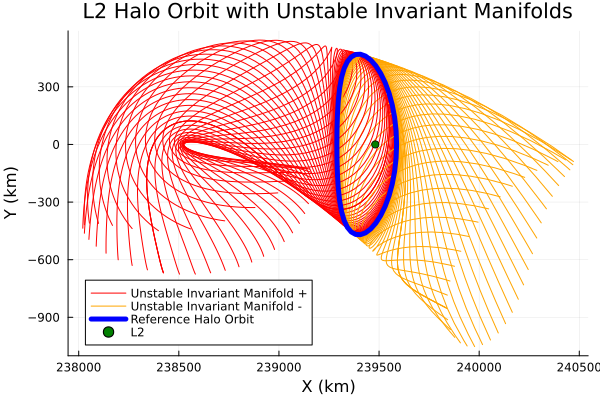

In [282]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left
epz = 3
#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit")

plot(reference_trajectory[1,:], reference_trajectory[2,:], label=nothing)

all_state_mplus = 0

all_state_mminus = 0
for i=1:41

    #initial_state = reference_trajectory[:,i] + epz.*unstable_directions[:,i]

    initial_state_plus = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    initial_state_minus = reference_trajectory[:,i] - epz.*[unstable_directions[1:3,i];zeros(3)]

    #initial_state = reference_trajectory[:,i] - epz.*unstable_directions[:,i]

    inv_manifold_plus = just_dynamics_integrate(initial_state_plus, 1.5*sol_t_final[end])

    inv_manifold_minus = just_dynamics_integrate(initial_state_minus, 1.45*sol_t_final[end])

    all_state_mplus = get_state(inv_manifold_plus)

    all_state_mminus = get_state(inv_manifold_minus)

    #plot!(all_state_m[1,:], all_state_m[2,:], all_state_m[3,:], color="red", legend=false)

    plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label=nothing)
    plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label=nothing)

end

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit", linewidth = 5)


plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label = "Unstable Invariant Manifold +")
plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label = "Unstable Invariant Manifold -")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Halo Orbit", linewidth = 5, xlabel = "X (km)", ylabel = "Y (km)", color="blue")
orbit_manifolds = scatter!([XL2[1]*L], [0], markercolor = "green", label = "L2", legend=true, title = "L2 Halo Orbit with Unstable Invariant Manifolds")

#savefig(orbit_manifolds, "orbit_manifolds")

In [283]:
XL2*L 

6-element Vector{Float64}:
 239481.19345626
      0.0
      0.0
      0.0
      0.0
      0.0

In [284]:
#two orbits worth of data
unstable_constraint = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
 -0.0141548    -0.0138869   -0.0136137   …  -0.0144143    -0.0141548
  0.00458043    0.00488325   0.00522698      0.00432203    0.00458043
 -0.000949301  -0.00115698  -0.00133631     -0.000713749  -0.000949301
 -0.89257      -0.872913    -0.851182       -0.910126     -0.89257
  0.425321      0.462972     0.501229        0.388763      0.425321
 -0.148995     -0.15317     -0.155061    …  -0.142499     -0.148995

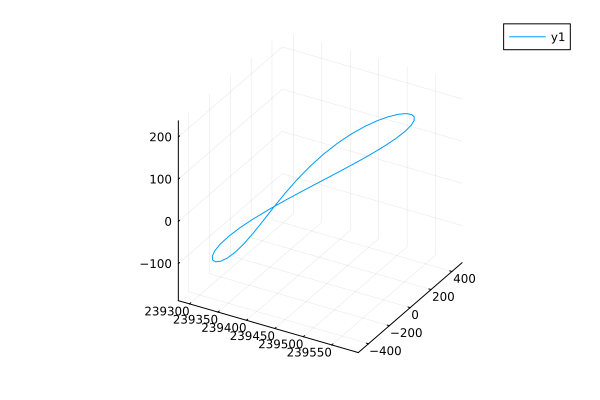

In [286]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])
#scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])
#scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

In [287]:
#obtain the reference trajectory at the knot points that we made up

#reference_trajectory = get_reference(1,N_period)

In [288]:
#goal is to have a look ahead of 2 orbits and apply an MPC controller 

#3 periods worth of data (just using the same orbit over the 3 periods)
#reference_trajectory_all = [reference_trajectory reference_trajectory reference_trajectory]

In [289]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = u/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled_RK4 (generic function with 1 method)

In [290]:
sol_t_final[end]

0.10746432599064995

In [291]:
#RK4 integrator with a zero order hold

function RK4_integrator(x, u)

    f1 = three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)
    f2 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f1, u)
    f3 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f2, u)
    f4 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+ Δt*f3, u)

    xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

    return xnext

end



RK4_integrator (generic function with 1 method)

In [292]:
reference_trajectory

6×41 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.7106            70.7106          2.50111e-8
    226.168           224.14             224.14          226.168
     -5.9486e-9     -1829.05            1829.05           -4.82299e-6
 -26419.7          -26119.7           -26119.7        -26419.7
     -6.13861e-9    -1508.04       …    1508.04           -8.12303e-7

In [293]:
u0 = zeros(3)
Ak_rk4 = ForwardDiff.jacobian(x_-> RK4_integrator(x_, u0), reference_trajectory[:,1])

6×6 Matrix{Float64}:
  1.02015     -0.000696091   0.00370582  …  0.000206734   3.31474e-6
 -0.00142523   0.994037     -0.00027359     0.00267059   -2.38997e-7
  0.00371632  -8.25675e-5    0.991821       1.69488e-8    0.00267927
 15.0058      -0.776788      2.75236        0.153571      0.00369167
 -1.59281     -4.40607      -0.304876       0.982132     -0.000355057
  2.76794     -0.0920887    -6.08133     …  2.59774e-5    0.991814

In [294]:
Bk_rk4 = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,1], u_), u0)

6×3 Matrix{Float64}:
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

In [295]:
for i=1:N_period

    #get the discrete dynamics jacobians for the entire reference trajectory along the knot points

    #Ak = ForwardDiff.jacobian(x-> three_body_prob_dynamics_scaled(x), reference_trajectory[:,i])
    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(x_, zeros(3)), reference_trajectory[:,i])

    #this is including the slack variable in the control vector (this is control on accelerations/thrust)
    #Bk = [zeros(3,3); I]

    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,i], u_), zeros(3))

    #this is the A tilde to get the discretized dynamics
    # Ãk = [Ak Bk; zeros(3,9)]

    # H = exp(Ãk*Δt)

    # all_Ad[:,:,i] = H[1:nx, 1:nx]

    # all_Bd[:,:,i] = H[1:nx, nx+1:end]
    
    
end

In [296]:
all_Bd[:,:,1]

6×3 Matrix{Float64}:
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

In [297]:
all_Ad[:,:,1] 

6×6 Matrix{Float64}:
  1.02015     -0.000696091   0.00370582  …  0.000206734   3.31474e-6
 -0.00142523   0.994037     -0.00027359     0.00267059   -2.38997e-7
  0.00371632  -8.25675e-5    0.991821       1.69488e-8    0.00267927
 15.0058      -0.776788      2.75236        0.153571      0.00369167
 -1.59281     -4.40607      -0.304876       0.982132     -0.000355057
  2.76794     -0.0920887    -6.08133     …  2.59774e-5    0.991814

In [298]:
all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

[:, :, 2] =
  3.61385e-6    1.8449e-7     2.1907e-9
 -1.86579e-7    3.59825e-6   -2.18877e-10
  2.1907e-9    -2.18877e-10   3.60397e-6
  0.0026939     0.000205448   3.22311e-6
 -0.000209066   0.00267074   -5.01936e-7
  3.25212e-6   -2.52418e-7    0.00267921

[:, :, 3] =
  3.61374e-6    1.83819e-7    2.11365e-9
 -1.8725e-7     3.59841e-6   -3.49645e-10
  2.11365e-9   -3.49645e-10   3.60392e-6
  0.00269372    0.000204462   3.08785e-6
 -0.000210059   0.002671     -6.85184e-7
  3.13133e-6   -4.45518e-7    0.00267912

;;; … 

[:, :, 79] =
  3.61385e-6   1.86576e-7   2.19073e-9
 -1.84493e-7   3.59825e-6   2.18328e-10
  2.19073e-9   2.18328e-10  3.60397e-6
  0.00269396   0.000208554  3.29185e-6
 -0.000205958  0.00

In [299]:
#concatenate jacobians for two periods

# all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
# all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [300]:
N_period

41

In [301]:
num_revs = 10

10

In [302]:
#1 revolution is 14 days
T*time_scale/60/60/24

1.2438000693362261e-6

In [303]:
T*time_scale

0.10746432599064995

In [304]:
N_h

81

In [305]:
#compute backward ricatti recursion

#cost to go matrices
#P = zeros((6,6,N_period*num_revs)) #size state x state (6x6) 
#K = zeros((3,6,N_period*num_revs)) #size control x state (3x6)

#cost to go matrices for 16 revs
P = zeros((6,6,N_period+((N_period-1)*15))) #size state x state (6x6) 
K = zeros((3,6,N_period+((N_period-1)*15))) #size control x state (3x6)

#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-3

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-3

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e3

3×3 Matrix{Float64}:
 1000.0     0.0     0.0
    0.0  1000.0     0.0
    0.0     0.0  1000.0

In [306]:
N_period+((N_period-1)*15)

641

In [307]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 639] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 640] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0

In [308]:
#1:(N_period*num_revs) - 1

In [309]:
#all_Ad_rev = all_Ad

In [310]:
all_Ad_16 = all_Ad
all_Bd_16 = all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  3.6139e-6     1.85183e-7    2.23021e-9
 -1.85886e-7    3.59817e-6   -7.46841e-11
  2.23021e-9   -7.46841e-11   3.604e-6
  0.002694      0.000206472   3.30443e-6
 -0.000208038   0.00267059   -2.93532e-7
  3.3172e-6    -3.83812e-8    0.00267926

[:, :, 2] =
  3.61385e-6    1.8449e-7     2.1907e-9
 -1.86579e-7    3.59825e-6   -2.18877e-10
  2.1907e-9    -2.18877e-10   3.60397e-6
  0.0026939     0.000205448   3.22311e-6
 -0.000209066   0.00267074   -5.01936e-7
  3.25212e-6   -2.52418e-7    0.00267921

[:, :, 3] =
  3.61374e-6    1.83819e-7    2.11365e-9
 -1.8725e-7     3.59841e-6   -3.49645e-10
  2.11365e-9   -3.49645e-10   3.60392e-6
  0.00269372    0.000204462   3.08785e-6
 -0.000210059   0.002671     -6.85184e-7
  3.13133e-6   -4.45518e-7    0.00267912

;;; … 

[:, :, 39] =
  3.61385e-6   1.86576e-7   2.19073e-9
 -1.84493e-7   3.59825e-6   2.18328e-10
  2.19073e-9   2.18328e-10  3.60397e-6
  0.00269396   0.000208554  3.29185e-6
 -0.000205958  0.00

In [311]:
for i = 2:16
    all_Ad_16 = cat(all_Ad_16, all_Ad[:,:,2:end], dims = 3)
    all_Bd_16 = cat(all_Bd_16, all_Bd[:,:,2:end], dims = 3)
end


In [312]:
# all_Ad_4 = cat(all_Ad_1, all_Ad_1, dims=3)
# all_Bd_4 = cat(all_Bd_1, all_Bd_1, dims=3)

# all_Ad_8 = cat(all_Ad_4, all_Ad_4, dims=3)
# all_Bd_8 = cat(all_Bd_4, all_Bd_4, dims=3)

# all_Ad_16 = cat(all_Ad_8, all_Ad_8, dims=3)
# all_Bd_16 = cat(all_Bd_8, all_Bd_8, dims=3)

In [313]:
# for i = 1:num_revs
#     all_Ad_rev = (all_Ad_rev, all_Ad, dims=3)
# end

In [314]:
# P[:,:,end] = Qf

# for k = reverse(1:(N_period*num_revs) - 1)
    
#     K[:,:,k] = (R + all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k])\(all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:, k]) # ricatti recursion for both A and B matrices changing
#     P[:,:,k] = Q + all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:,k] - all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k]*K[:,:,k]
 
# end 

In [315]:
#Ricatti recursion over 2 periods
P[:,:,end] = Qf

for k = reverse(1:640)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [316]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

[:, :, 2] =
  2.8317e11   -1.07258e11   3.48386e10  …       1.05668e9       1.74498e8
 -1.07258e11   4.0627e10   -1.31961e10         -4.00245e8      -6.60959e7
  3.48386e10  -1.31961e10   4.28623e9           1.30004e8       2.14686e7
  3.52403e9   -1.33482e9    4.33564e8           1.31503e7       2.17162e6
  1.05668e9   -4.00245e8    1.30004e8           3.94309e6  651157.0
  1.74498e8   -6.60959e7    2.14686e7   …  651157.0             1.07533e5

[:, :, 3] =
  2.76538e11  -1.16154e11   3.18155e10  …       9.

In [317]:
P[:,:,1]

6×6 Matrix{Float64}:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

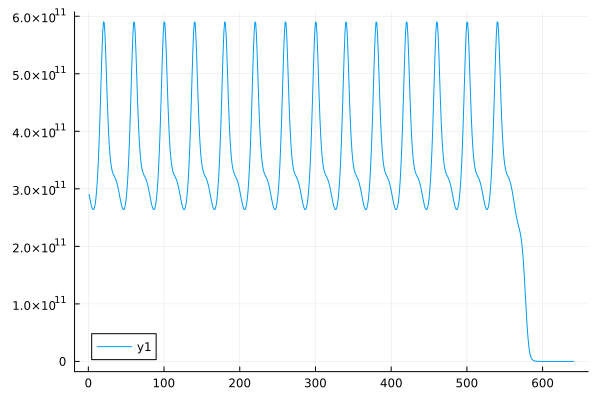

In [318]:
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [319]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

[:, :, 2] =
  2.8317e11   -1.07258e11   3.48386e10  …       1.05668e9       1.74498e8
 -1.07258e11   4.0627e10   -1.31961e10         -4.00245e8      -6.60959e7
  3.48386e10  -1.31961e10   4.28623e9           1.30004e8       2.14686e7
  3.52403e9   -1.33482e9    4.33564e8           1.31503e7       2.17162e6
  1.05668e9   -4.00245e8    1.30004e8           3.94309e6  651157.0
  1.74498e8   -6.60959e7    2.14686e7   …  651157.0             1.07533e5

[:, :, 3] =
  2.76538e11  -1.16154e11   3.18155e10  …       9.7

In [320]:
V[:,:,1]

6×6 Matrix{Float64}:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

In [321]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

[:, :, 2] =
  2.8317e11   -1.07258e11   3.48386e10  …       1.05668e9       1.74498e8
 -1.07258e11   4.0627e10   -1.31961e10         -4.00245e8      -6.60959e7
  3.48386e10  -1.31961e10   4.28623e9           1.30004e8       2.14686e7
  3.52403e9   -1.33482e9    4.33564e8           1.31503e7       2.17162e6
  1.05668e9   -4.00245e8    1.30004e8           3.94309e6  651157.0
  1.74498e8   -6.60959e7    2.14686e7   …  651157.0             1.07533e5

[:, :, 3] =
  2.76538e11  -1.16154e11   3.18155e10  …       9.7

In [322]:
V_first = V_2orbits[:,:,1]

6×6 Matrix{Float64}:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

In [323]:
V_first'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

In [324]:
difference = V_first - V_first'

6×6 Matrix{Float64}:
  0.0          -0.000137329  -0.00012207  …   2.6226e-6    3.75509e-6
  0.000137329   0.0          -8.96454e-5     -6.55651e-7  -1.40071e-6
  0.00012207    8.96454e-5    0.0             2.17557e-6   7.7337e-6
  1.43051e-6   -1.19209e-6    1.19209e-7      1.86265e-9   1.4808e-7
 -2.6226e-6     6.55651e-7   -2.17557e-6      0.0         -1.77883e-7
 -3.75509e-6    1.40071e-6   -7.7337e-6   …   1.77883e-7   0.0

In [325]:
difference2 = V_2orbits[:,:,2] - V_2orbits[:,:,2]'

6×6 Matrix{Float64}:
  0.0          -6.10352e-5   -0.000114441  …   2.86102e-6   4.08292e-6
  6.10352e-5    0.0          -0.000106812     -1.07288e-6  -2.63751e-6
  0.000114441   0.000106812   0.0              3.18885e-6   7.62194e-6
  9.53674e-7   -1.19209e-6    5.96046e-7       3.72529e-9   1.36439e-7
 -2.86102e-6    1.07288e-6   -3.18885e-6       0.0         -1.78814e-7
 -4.08292e-6    2.63751e-6   -7.62194e-6   …   1.78814e-7   0.0

In [326]:
symmetric_v1 = (V_first + V_first')/2

6×6 Matrix{Float64}:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

In [327]:
#needed for the quadratic constraint
invsymmetricv1 = inv(symmetric_v1)

6×6 Matrix{Float64}:
  0.0614627    0.0202735    0.00401399   -3.86616   -1.84004   -0.648699
  0.0202735    0.0086309    0.00182335   -1.23004   -0.598494  -0.214388
  0.00401399   0.00182335   0.00257841   -0.26378   -0.122369  -0.0232637
 -3.86616     -1.23004     -0.26378     244.547    115.786     40.6035
 -1.84004     -0.598494    -0.122369    115.786     55.7775    19.2388
 -0.648699    -0.214388    -0.0232637    40.6035    19.2388     7.55684

In [328]:
invsymmetricv1 - invsymmetricv1'

6×6 Matrix{Float64}:
  0.0          -7.75557e-11  -1.55272e-10  …  -6.49505e-10   1.9989e-10
  7.75557e-11   0.0          -3.41472e-11     -2.53872e-9   -6.65338e-10
  1.55272e-10   3.41472e-11   0.0             -4.6939e-9    -1.60132e-9
  2.90652e-10   5.10568e-9    1.01151e-8       3.21139e-8   -1.35121e-8
  6.49505e-10   2.53872e-9    4.6939e-9        0.0          -1.28341e-8
 -1.9989e-10    6.65338e-10   1.60132e-9   …   1.28341e-8    0.0

In [329]:
display(V_first)

6×6 Matrix{Float64}:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

In [330]:
#far_deviation = [1, 0, 1, 0, 1, 0]

In [331]:
#cost to go for this far deviation
#far_deviation'*inv(V_first)*far_deviation

In [332]:
#get the initial delta x
#this is some noise on the reference trajectory

#some arbitrary deviation from the reference trajectory
#x_initial_ref = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]

#this is working
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#this is working. Pretty far deviation in x = 385 km, and vy off by ~1e-3 km/s
#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]


#off by 385 km meters and ~1 mm/s

#x_initial_ref = [1e-3, 0, 0, 0, 1e-6, 0]


#try a small deviation
#works great with a small deviation
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#trying a larger deviation
#these are in CR3BP units
x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]

x_initial_ref_scaled = [x_initial_ref[1:3]*L; x_initial_ref[4:6]*V_]

#ensure that the initial deviation is in the unstable manifold direction
#x_initial_ref = [1e-9, -1e-9, 1e-9, 1e-9, -1e-9, 1e-9]

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [333]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 6.84659085618205
 0.0

In [334]:
x_initial_ref_scaled'*V[:,:,1]*x_initial_ref_scaled

2.048113761445221e10

In [335]:
V[:,:,20]

6×6 Matrix{Float64}:
  5.90007e11  -5.85883e10  -1.01632e11   4.32925e9   3.70237e9  -6.18475e8
 -5.85883e10   5.81787e9    1.00921e10  -4.29899e8  -3.67648e8   6.14151e7
 -1.01632e11   1.00921e10   1.75066e10  -7.45737e8  -6.37752e8   1.06536e8
  4.32925e9   -4.29899e8   -7.45737e8    3.17664e7   2.71666e7  -4.53814e6
  3.70237e9   -3.67648e8   -6.37752e8    2.71666e7   2.32328e7  -3.881e6
 -6.18475e8    6.14151e7    1.06536e8   -4.53814e6  -3.881e6     6.48318e5

In [336]:
V[:,:,end]

6×6 Matrix{Float64}:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

In [337]:
test = eigen(V[:,:,20]).values

6-element Vector{Float64}:
    0.00303292506121422
    0.4146849353839198
    0.6769767771612193
  656.9445432085347
 1721.515624260962
    6.133876241019685e11

In [338]:
1/sqrt(test[6])

1.2768282865279466e-6

In [339]:
#concatenate unstable directions for 2 orbits

unstable_directions_2 = cat(unstable_directions, unstable_directions[:, 2:end], dims=2)

6×81 Matrix{Float64}:
 -0.0141548    -0.0138869   -0.0136137   …  -0.0144143    -0.0141548
  0.00458043    0.00488325   0.00522698      0.00432203    0.00458043
 -0.000949301  -0.00115698  -0.00133631     -0.000713749  -0.000949301
 -0.89257      -0.872913    -0.851182       -0.910126     -0.89257
  0.425321      0.462972     0.501229        0.388763      0.425321
 -0.148995     -0.15317     -0.155061    …  -0.142499     -0.148995

In [340]:
# V_2orbits

In [774]:
tube_pose_r = 1000
tube_vel_r = 1000

1000

In [775]:
x_initial_ref[:,1]

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [776]:
# c_test= unstable_directions[:,1]/tan(pi/6)

# manifold_constraint_test = norm(x_initial_ref[:,1]) - c_test'*(x_initial_ref[:,1])

In [777]:
# dot(x_initial_ref[:,1], unstable_directions[:,1])

In [778]:
# dot(reference_trajectory[:,1] + x_initial_ref, unstable_directions[:,1])

In [779]:
# test = (reference_trajectory[:,1] + x_initial_ref)/norm(reference_trajectory[:,1] + x_initial_ref)

In [780]:
# dot(test, unstable_directions[:,1])

In [781]:
# L

In [782]:
# dot(x_initial_ref, unstable_directions[:,1])

In [783]:
all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.02015     -0.000696091   0.00370582  …  0.000206734   3.31474e-6
 -0.00142523   0.994037     -0.00027359     0.00267059   -2.38997e-7
  0.00371632  -8.25675e-5    0.991821       1.69488e-8    0.00267927
 15.0058      -0.776788      2.75236        0.153571      0.00369167
 -1.59281     -4.40607      -0.304876       0.982132     -0.000355057
  2.76794     -0.0920887    -6.08133     …  2.59774e-5    0.991814

[:, :, 2] =
  1.02001     -0.00184642    0.00363856   …   0.000205704   3.24762e-6
 -0.00257715   0.99421      -0.000512787      0.00267071   -4.51814e-7
  0.00366136  -0.000324786   0.991786        -2.00404e-7    0.00267923
 14.8698      -1.62786       2.68976          0.152425      0.0036031
 -2.44585     -4.23881      -0.479556         0.98229      -0.000588374
  2.71888     -0.270616     -6.1127       …  -0.000214923   0.991765

[:, :, 3] =
  1.01979     -0.00295756    0.00350921   …   0.000204708   3.12539e-6
 -0.00369204   0.994509     

In [784]:
#this is the reference trajectory for 2 orbits starting at the beginning
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.7106            70.7106          2.50111e-8
    226.168           224.14             224.14          226.168
     -5.9486e-9     -1829.05            1829.05           -4.82299e-6
 -26419.7          -26119.7           -26119.7        -26419.7
     -6.13861e-9    -1508.04       …    1508.04           -8.12303e-7

In [785]:
reference_trajectory_half = cat(reference_trajectory[:,21:end], reference_trajectory[:,2:21], dims=2)

#this is the reference trajectory starting at the half 21
reference_trajectory2_2 = cat(reference_trajectory_half, reference_trajectory_half[:,2:end], dims=2)

6×81 Matrix{Float64}:
     2.39289e5       2.3929e5      2.39292e5  …      2.3929e5      2.39289e5
    -1.11574e-7     80.0752      157.408           -80.0752       -1.11574e-7
  -175.727        -172.391      -162.594          -172.391      -175.727
     1.84934e-5    541.06       1188.98           -541.062         1.84934e-5
 29978.8         29460.0       27953.6           29460.0       29978.8
    -1.43134e-5   2469.86       4786.75       …  -2469.85         -1.43134e-5

In [786]:
#get the reference trajectory when you are starting at the half


In [787]:
#dynamics_wcontrol_integrate([reference_trajectory2[:,1]; zeros(3)], Δt).u[end][1:6]

In [788]:
#cost to go level set
#works with 0.1

#THIS EPSILON IS WORKING
#epsilon = 1

epsilon = 1

umax = 0.025

0.025

In [789]:
x_initial_ref'*P[:,:,1]*x_initial_ref

0.2924885133737412

In [790]:
P[:,:,end]

6×6 Matrix{Float64}:
 0.001  0.0    0.0    0.0    0.0    0.0
 0.0    0.001  0.0    0.0    0.0    0.0
 0.0    0.0    0.001  0.0    0.0    0.0
 0.0    0.0    0.0    0.001  0.0    0.0
 0.0    0.0    0.0    0.0    0.001  0.0
 0.0    0.0    0.0    0.0    0.0    0.001

In [791]:
P[:,:,1]

6×6 Matrix{Float64}:
  2.90183e11  -9.72514e10   3.74168e10   3.55464e9   1.15029e9   2.38395e8
 -9.72514e10   3.25926e10  -1.25398e10  -1.19129e9  -3.85505e8  -7.98952e7
  3.74168e10  -1.25398e10   4.8246e9     4.58342e8   1.48321e8   3.07391e7
  3.55464e9   -1.19129e9    4.58342e8    4.3543e7    1.40906e7   2.92025e6
  1.15029e9   -3.85505e8    1.48321e8    1.40906e7   4.55975e6   9.45e5
  2.38395e8   -7.98952e7    3.07391e7    2.92025e6   9.45e5      1.95851e5

In [792]:
#lower bound as 10 mm/s. Converting to an acceleration based off of our discretization as well as the units that we are using which 
#is km/day
lower_bound = 10/(Δt*86400)*(86400^2/1e6)

321.59509382682893

In [793]:
# #10 mm/s
# Tmin = lower_bound
# #1 m/s
# Tmax = 100*lower_bound

In [794]:
#formulate the problem at every solve


#pass in the initial condition, along with jacobians of the current reference trajectory 

#bias is a 6xN_h-1 matrix
function update_prob(x_initial_k, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, bias, reference_traj_k)
    
    #clear the constraints and decision variables every run
    #cons = 0
    #U = 0
    
    X = Variable(nx,N_h)
        
    U = Variable(nu, N_h-1)
    
    #initial state constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #state constraints
    #Dynamics constraint (for the entire horizon)
    
    # for k=1:(N_h-1)
    #     #these are the dynamics for delta x
        
    #     #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
    #     push!(cons, X[:,k+1] == all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    # end


    #dynamics constraint with bias
    for k=1:(N_h-1)
        #these are the dynamics for delta x
        
        #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        #check sign on the bias. parenthesis
        #push!(cons, zeros(6)== X[:,k+1] - all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k] - bias[:,k])
        
        #kinda working
        #push!(cons, zeros(6)== X[:,k+1] - (all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k]) - bias[:,k])

        #Linear affine term in terms of Δx and Δu (the integrator is there because the reference trajectory is not dynamically feasible)
        #(x̄+Δx) - (f(x̄,ū) + AΔx + BΔu) - bias
        push!(cons, zeros(6)== reference_traj_k[:,k+1] + X[:,k+1] - (dynamics_wcontrol_integrate([reference_traj_k[:,k]; zeros(3)], Δt).u[end][1:6] + all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[1:3,k]) - bias[:,k])

        
        #in terms of x's
        #prob.constraints += X[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*(X[:,i] - X̄[i]) + B[i]*(U[:,i] - Ū[i])
        #in terms of deltas
        #prob.constraints += X̄[i+1] + ΔX[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*ΔX[:,i] + B[i]*ΔU[:,i]


    end

    
    #already propagating the deltas since we are linearizing the dynamics about the reference trajectories
    
#     for k=1:(N_h-1)        
#         #Box constraints on the deviation from the reference trajectory
                
#         push!(cons, X[1,k] <= xmax)
#         push!(cons, X[1,k] >= -xmax)
#         push!(cons, X[2,k] <= ymax)
#         push!(cons, X[2,k] >= -ymax)
#         push!(cons, X[3,k]<= zmax)
#         push!(cons, X[3,k] >= -zmax)
         
#     end
    
    
    #tube constraint
    #for k=2:(N_h-1) #this was there before and works
    #THIS WORKS and gives nice impluses. removes the noise. HIGH tube pose r
    for k=1:N_h 
       push!(cons, norm(X[1:3,k],2) <= tube_pose_r)
    
       push!(cons, norm(X[4:6,k],2) <= tube_vel_r)
         
    end
    
    
    #cost to go constraint (Working, most current)
    # for k=2:N_h
        
    #    costtogo = P_k[:,:,k]
        
    #    costtogo_hermitian = (costtogo + costtogo')/2
        
    #    #relaxing bc of the manifold constraint
    #    ctg_constraint = quadform(X[:,k], costtogo_hermitian) <= epsilon
        
    #    push!(cons, ctg_constraint)
                
    # end
    
    #manifold constraint (useful)
    #the delta x needs to be normalized
    #exits to the left with the negative sending
    #this is what is used. for some reason it is being infeasbile in problem 2
   #for k=1:N_h
#     for k=2:N_h 
        
#       #this works the best. investigate why 
#       #manifold goes to the left.  (w no ctg constraint)
#       #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.5*norm(X[:,k]))
        
        
#       #testing  (working) 
#       #goes left with positive unstable direction
#       manifold_constraint = dot(X[:,k], 1*unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.1*norm(X[:,k]))

#       #push!(cons, manifold_constraint >= 0)

#       #trying out 
#       push!(cons, manifold_constraint > 0)

                
        
#    end



#this is working
# for k = 2:N_h
# #to have this at 1, the initial deviation has to satisfy this constraint off the bat. 
# #for k = 1:N_h
            
#     #manifold goes to the right
#     #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
#     manifold_constraint = X[:,k]'*unstable_directions_k[:,k]
    
#     #currently working
#     #push!(cons, manifold_constraint > 0)

#     #add some slack (works with the positive stable directions. negative stable directions still some that don't satisfy fully)
#     #push!(cons, manifold_constraint > 1e-6)

#     #will try bumping up the slack (tried 1e-5, worked better but not 100%)
#     #1e-4 works good 
#     #works good 1e-3
#     #works with 1e-1 but at a higher cost
#     push!(cons, manifold_constraint > 1e-2)
    
# end




   #manifold glideslope constraint for the whole unstable direction

#    for k=2:N_h
#     for k=1:N_h

#         #works with pi/5 too
#         c = unstable_directions_k[:,k]/tan(pi/6)

#         manifold_constraint = norm(X[:,k]) - c'*(X[:,k])

#         push!(cons, manifold_constraint <= 0)

#    end

#currently the one being used
# for k=2:N_h
        
#     #works with pi/5 too
#     c = unstable_directions_k[:,k]/tan(pi/6)
#     #c = unstable_directions_k[:,k]/tan((pi/2) - deg2rad(60)

#     manifold_constraint = norm(X[:,k]) - c'*X[:,k]

#     push!(cons, manifold_constraint <= 0)

# end

    
     
    #Controls Constraint
    #convexification constraint

    # for k=1:(N_h-1)

    #     push!(cons, Tmin <= U[1,k])
    #     push!(cons, Tmin <= U[2,k])
    #     push!(cons, Tmin <= U[3,k])

    # end
    
    #not working
    # for k=1:(N_h-1)

    #     σ1 = U[4,k]

    #     push!(cons, Tmin <= σ1)

    #     push!(cons, norm(U[1:3, k]) <= min(σ1, Tmax))

    # end
        
    #    push!(cons, U[1:3, k]> umin)
        
        
        #not working
        #σ = U[4,k]
        
        #convexified non convex constraint lower bound
        #push!(cons, umin <= σ)
        
        #convexified non convex constraint upper bound
        #push!(cons, σ <= umax)
        
        #convex upper bound on the thrust norm
        #push!(cons, norm(U[1:3,k]) <= σ)
        
        
        #upper bound
        #push!(cons, norm(U[1:3,k]) <= min(σ, umax))
        
        
    #end
    
    #print("done")
    
    return cons, X, U
        
end

update_prob (generic function with 1 method)

In [795]:
unstable_directions[:,1]

6-element Vector{Float64}:
 -0.014154755627771133
  0.0045804331963484905
 -0.0009493005547567748
 -0.8925696587902248
  0.42532071609297856
 -0.1489948120659455

In [796]:
#create the optimization problem

function solve_opt(cons, X, U, N)
    
    #these are tuning parameters
    
    #controls how tight you are tracking the reference 
    #α = 1e3
    
    #controls how much control effort you want to use (high value = low control)
    #β = 1e6
    #β = [1e6, 1e6, 1e15]
    #β = [1e3, 1e3, 1e3]
    #works with 1
    #works good with 1e-4 on just tracking and 0 on controls
    #β = 0
    #α = 1e-5

    #testing
    β = 1e6
    α = 1

    
    #β = 1 #some of the revs are slow to solve and solution may be innacurate
    
    #the cost function (L1 norm on the cost and the tracking error)
    obj = 0
    
    #for k=1:N
    #    obj += α*norm(X[:,k], 1)
    #end
    
    
    #for a lyaponov orbit we want to stay in the x y plane, so we penalize z maneuvers heavily while 
    #allowing for x and y
    
    for k=1:N-1
        
       #obj += β[1]*abs(U[1,k])+β[2]*abs(U[2,k]) +β[3]*abs(U[3,k])  
        
       #obj += β*norm(U[:,k], 1)
        
        #use L2 norm
        
        #^2 doesn't work in Convex.jl. have to use quadform 
        #obj += β*(norm(U[:,k]))^2 + α*(norm(X[:,k]))^2

        #obj = (norm(X[:,k]))^2

        
        #Px = 1.0*Matrix(I,6,6)

        #Pu = 1.0*Matrix(I,3,3)  
        #this gives the expected behavior with the manifolds but it does not minimize for cost
        #obj += quadform(X[:,k], Px; assume_psd=false)

        #obj += quadform(U[:,k], Pu; assume_psd=false)
        
        #this cost function works good, but gives continous thrust 
        #obj += quadform(U[:,k], Pu; assume_psd=false) + quadform(X[:,k], Px; assume_psd=false)
        #obj += β*norm(U[:,k], 1) + α*norm(X[:,k], 1)


        #this objective works well and gives impulsive thrust that bias the trajectory in a way for a safe escape left/right
        #obj += norm(U[:,k], 1) + 1e-2*norm(X[:,k], 1) 

        obj += norm(U[:,k], 1)

        
    end
            
    
    prob = minimize(obj, cons);
    
    #this objective function is working
    #prob = minimize(norm(X[:,end]), cons);
    
    #this works too
    #prob = minimize(quadform(X[:,end], Q), cons)
    
    #print("mosek solving")
    #solve the problem with Mosek
    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver= true);
    
    #solve the problem with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=false);
    
    Xm = X.value;
    Um = U.value;

    #display(prob.status)
    
    return Xm, Um
    
end

solve_opt (generic function with 1 method)

In [797]:
#Q = Matrix(I,6,6).*[1e7*ones(3); 1e7*ones(3)]

#the manifold constraint is the one that is not being satisfied. I think it has to do with numerical conditioning as the values are very small


In [798]:
x_initial_ref_scaled

6-element Vector{Float64}:
 -0.0012847898760810494
  0.001846615782575271
  0.011444266626313038
  0.05302767708961436
  0.0335958823634428
  0.1046367901145706

In [799]:
reference_trajectory[:,1] - reference_trajectory[:,end]

6-element Vector{Float64}:
  7.657217793166637e-8
 -2.5011070260512984e-8
  5.089333399155294e-9
  4.817042959041947e-6
 -2.3041975509840995e-6
  8.061639399190169e-7

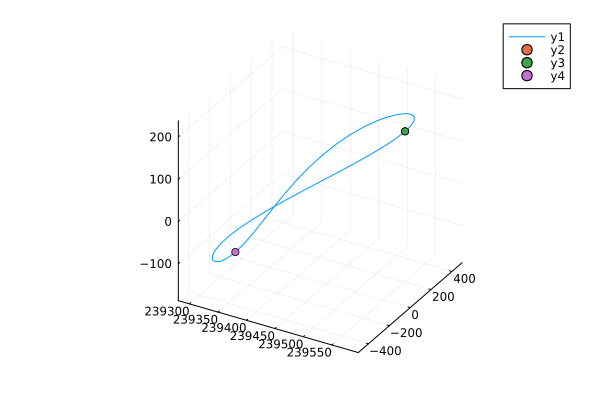

In [800]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])


#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

In [801]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [802]:
#reference_traj_1 = [reference_trajectory reference_trajectory]

In [803]:
x_initial_ref_scaled

6-element Vector{Float64}:
 -0.0012847898760810494
  0.001846615782575271
  0.011444266626313038
  0.05302767708961436
  0.0335958823634428
  0.1046367901145706

In [804]:
N_h

81

In [805]:
#just test to see if it solves

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)
bias_0 = zeros(6, N_h-1)

#there was nothing in place for all_Ad_1, maybe a bug? 
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, bias_0, reference_trajectory2)
display("solving")
display(X)
Xm, Um = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 160…387

([-0.0012847898760810494 -0.0011709975706916543 … 11.947689402812141 14.155278953459792; 0.001846615782575271 0.001916001496631287 … -3.584153897577944 -4.582415776533323; … ; 0.0335958823634428 0.01809983466965239 … -322.2821804413655 -425.37401512114644; 0.1046367901145706 0.030607960729968 … 118.33395388380623 149.15892007645547], [-14.176672110297362 -2.5418370845858394e-12 … 4.400107876491588e-12 2.385362676006963e-12; -1.2506086731545222e-12 -3.7632969706984066e-12 … 1.3931772475179526e-12 2.096191190596043e-12; 9.952621559406256e-14 -9.809823930164333e-13 … 4.405367424669779e-13 1.0173551767815617e-12])

In [806]:
Um

3×80 Matrix{Float64}:
 -14.1767       -2.54184e-12   2.0522e-13   …  4.40011e-12  2.38536e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12     1.39318e-12  2.09619e-12
   9.95262e-14  -9.80982e-13   3.18536e-12     4.40537e-13  1.01736e-12

In [808]:
#check the constraint

#this is because the constraint is from 2:Nh
constraint_satisfied = zeros(N_h)

for i=1:N_h
    constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
end

#constraint is not being satisfied... has to do with the cost function. whenever I have a
#tracking cost with a weight of 1e-2 and a control cost with scale 1, it doesn't work. However, 
#when I remove the cost on the controls and make the weight less on the tracking (1e-5) it works (up to the last point)

#with just a tracking cost with a weight of 1e-2 it doesn't satisfy the constraint fully

In [809]:
constraint_satisfied[1]

-0.048616429641721345

In [810]:
constraint_satisfied[15]

-0.037887604782341065

In [811]:

Xm[:,18]/norm(Xm[:,18])

6-element Vector{Float64}:
 -0.0023368077092652136
 -0.00287235938450261
 -0.012710647678433232
 -0.14722946797526468
 -0.0671555456044884
 -0.9867311410770286

In [812]:
unstable_directions[:,18]

6-element Vector{Float64}:
 -0.008960696787909209
  0.009564799953762781
 -0.00010338738082673086
 -0.6961059718901272
  0.7069615032521865
  0.12437893167365383

In [813]:
constraint_satisfied[60:70]

11-element Vector{Float64}:
  -28.188197161976213
  -34.34428025987966
  -41.386897244579515
  -49.31081771433219
  -58.16594731521694
  -68.09692385151594
  -79.34871651612308
  -92.26440711209506
 -107.28354987969507
 -124.94100352324085
 -145.87878936579384

In [814]:
constraint_satisfied

81-element Vector{Float64}:
    -0.048616429641721345
    -0.023883917849873808
    -0.030832743871353784
    -0.0365953656141958
    -0.041091037508508496
    -0.04455375387294041
    -0.04618246578666468
    -0.04684294280566064
    -0.0468176362880858
    -0.047159979782156615
     ⋮
  -237.00409519692033
  -280.7032728593576
  -333.69148554628805
  -398.07934123463224
  -476.42221385027653
  -571.7960162995175
  -687.8629866238208
  -828.9451206866447
 -1000.1111279586838

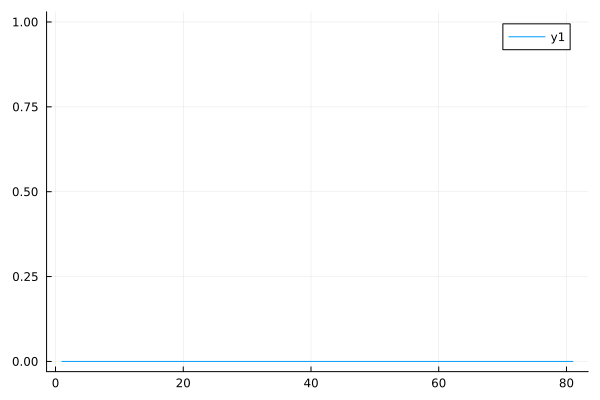

In [815]:
constraint_bool = constraint_satisfied .> 0

plot(constraint_bool)

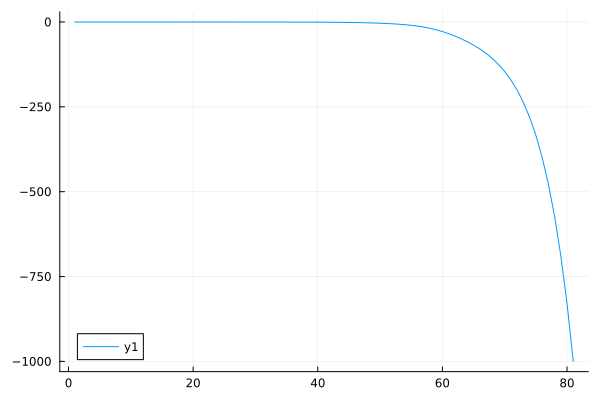

In [816]:
plot(constraint_satisfied)

In [817]:
constraint_satisfied

81-element Vector{Float64}:
    -0.048616429641721345
    -0.023883917849873808
    -0.030832743871353784
    -0.0365953656141958
    -0.041091037508508496
    -0.04455375387294041
    -0.04618246578666468
    -0.04684294280566064
    -0.0468176362880858
    -0.047159979782156615
     ⋮
  -237.00409519692033
  -280.7032728593576
  -333.69148554628805
  -398.07934123463224
  -476.42221385027653
  -571.7960162995175
  -687.8629866238208
  -828.9451206866447
 -1000.1111279586838

In [818]:
constraint_bool[44]

false

In [819]:
Xm 

6×81 Matrix{Float64}:
 -0.00128479  -0.001171   -0.0010656   …    11.9477      14.1553
  0.00184662   0.001916    0.00194336       -3.58415     -4.58242
  0.0114443    0.0116261   0.0116079         0.601195     0.959421
  0.0530277    0.0316041   0.0454784       754.404      892.641
  0.0335959    0.0180998   0.00199316     -322.282     -425.374
  0.104637     0.030608   -0.0443017   …   118.334      149.159

In [820]:
residual = zeros(6, N_h-1)

6×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [821]:
reference_trajectory[:,1]

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -5.94859626923431e-9
 -26419.73544475346
     -6.138613580085994e-9

In [822]:
reference_trajectory[:,end]

6-element Vector{Float64}:
 239587.62743536415
      2.501107314628918e-8
    226.16844282250426
     -4.8229915553111815e-6
 -26419.735442449262
     -8.123025534991029e-7

In [823]:
input = [Xm[:,1] + reference_trajectory[:,1]; Um[:,1]]

9-element Vector{Float64}:
 239587.62615065085
      0.0018466157825781568
    226.1798870942199
      0.05302767114101809
 -26419.701848871096
      0.10463678397595702
    -14.176672110297362
     -1.2506086731545222e-12
      9.952621559406256e-14

In [824]:
#reference_trajectory2 = [reference_trajectory reference_trajectory]

In [825]:
#find the residual

for k = 1:N_h-1

    input = [Xm[:,k] + reference_trajectory2[:,k]; Um[:,k]]

    xnext_sol = dynamics_wcontrol_integrate(input, Δt)

    residual[:,k] = reference_trajectory2[:,k+1] + Xm[:,k+1] - xnext_sol.u[end][1:6]

end

In [826]:
residual

6×80 Matrix{Float64}:
 -3.9814e-7    1.14297e-6  -1.70546e-6  …  0.00140833   0.00220741
  3.87183e-7  -3.54255e-7  -1.40545e-7     0.000798435  0.000891713
 -1.55329e-7   1.2894e-7    6.95857e-8     0.000594599  0.000861255
 -8.15369e-7   6.20185e-6  -1.14073e-5     1.16213      1.80489
 -2.28829e-9   9.13835e-7   2.86541e-6     0.579873     0.626146
 -2.67449e-7  -5.9455e-8   -2.31349e-6  …  0.472485     0.682441

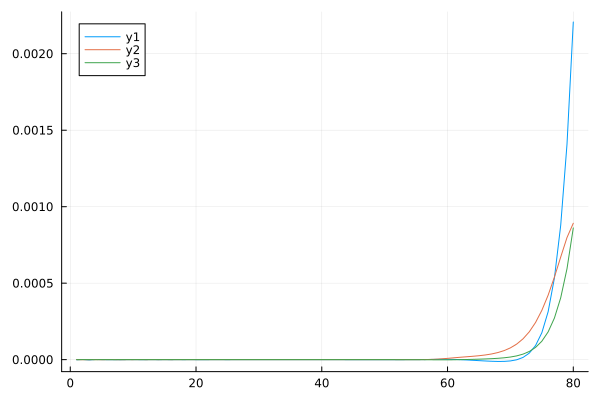

In [827]:
plot(residual[1,:])
plot!(residual[2,:])
plot!(residual[3,:])

In [828]:
#for one period 40 controls
xtraj_test = integrate_oneperiod(Xm[:,1] + reference_trajectory[:,1], Um[:,1:40])

6×41 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
      0.00184662     -70.7087            70.7082         -0.00301905
    226.18           224.152            224.151         226.18
      0.0530277    -1829.01            1829.54            0.600399
 -26419.7         -26119.7           -26119.9        -26420.0
      0.104637     -1508.01       …    1508.32            0.230483

In [829]:
# Xm[:,1]

In [830]:
delta_test = xtraj_test - reference_trajectory

6×41 Matrix{Float64}:
 -0.00128479  -0.0011706   -0.00106633  …   0.00665771   0.00811443
  0.00184662   0.00191561   0.00194332     -0.00240718  -0.00301908
  0.0114443    0.0116262    0.0116079       0.0108173    0.0114967
  0.0530277    0.0316049    0.04548         0.495711     0.600404
  0.0335959    0.0180998    0.00199271     -0.195237    -0.262467
  0.104637     0.0306082   -0.0443011   …   0.278597     0.230484

In [831]:
# dot(delta_test[:,1], unstable_directions[:,1])

In [832]:
# delta_test - Xm[:,1:41]

In [833]:
# xtraj_test[:,1] - reference_trajectory[:,1]

In [834]:
x_initial_ref_scaled

6-element Vector{Float64}:
 -0.0012847898760810494
  0.001846615782575271
  0.011444266626313038
  0.05302767708961436
  0.0335958823634428
  0.1046367901145706

In [835]:
# delta_test[:,1]

In [836]:
Xm[:,1]

6-element Vector{Float64}:
 -0.0012847898760810494
  0.001846615782575271
  0.011444266626313038
  0.05302767708961436
  0.0335958823634428
  0.1046367901145706

In [837]:
constraint_satisfied_ndynamics = zeros(41)

for i=1:41
    constraint_satisfied_ndynamics[i] = dot(delta_test[:,i], unstable_directions[:,i])
end

In [838]:
# delta_test[:,21]

In [839]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
 -0.048616429641721345
 -0.023884677101569197
 -0.030834397958254756
 -0.036597995425237506
 -0.04109475536613969
 -0.0445586139439532
 -0.04618854148945198
 -0.046850405131292606
 -0.04682666871577421
 -0.04717071078146033
  ⋮
 -0.15979281651391067
 -0.19230239948881392
 -0.23111842529336477
 -0.2777044365596145
 -0.33067270135228816
 -0.39360790118227607
 -0.4710703645272498
 -0.566875210890675
 -0.6820156371997752

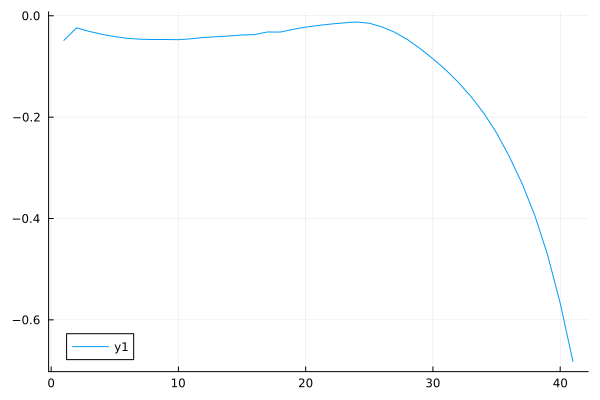

In [840]:
plot(constraint_satisfied_ndynamics)

In [841]:
constraint_satisfied

81-element Vector{Float64}:
    -0.048616429641721345
    -0.023883917849873808
    -0.030832743871353784
    -0.0365953656141958
    -0.041091037508508496
    -0.04455375387294041
    -0.04618246578666468
    -0.04684294280566064
    -0.0468176362880858
    -0.047159979782156615
     ⋮
  -237.00409519692033
  -280.7032728593576
  -333.69148554628805
  -398.07934123463224
  -476.42221385027653
  -571.7960162995175
  -687.8629866238208
  -828.9451206866447
 -1000.1111279586838

In [842]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
 -0.048616429641721345
 -0.023884677101569197
 -0.030834397958254756
 -0.036597995425237506
 -0.04109475536613969
 -0.0445586139439532
 -0.04618854148945198
 -0.046850405131292606
 -0.04682666871577421
 -0.04717071078146033
  ⋮
 -0.15979281651391067
 -0.19230239948881392
 -0.23111842529336477
 -0.2777044365596145
 -0.33067270135228816
 -0.39360790118227607
 -0.4710703645272498
 -0.566875210890675
 -0.6820156371997752

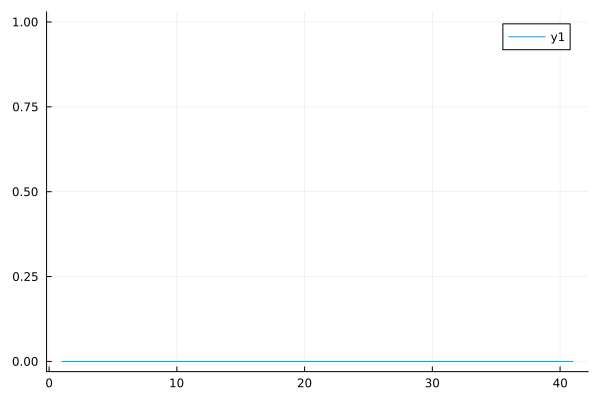

In [843]:
plot(constraint_satisfied_ndynamics .>0)

In [844]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
 -0.048616429641721345
 -0.023884677101569197
 -0.030834397958254756
 -0.036597995425237506
 -0.04109475536613969
 -0.0445586139439532
 -0.04618854148945198
 -0.046850405131292606
 -0.04682666871577421
 -0.04717071078146033
  ⋮
 -0.15979281651391067
 -0.19230239948881392
 -0.23111842529336477
 -0.2777044365596145
 -0.33067270135228816
 -0.39360790118227607
 -0.4710703645272498
 -0.566875210890675
 -0.6820156371997752

In [845]:
final = Xm + [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39597e5       2.39602e5
      0.00184662     -70.7087            67.1264         -4.58242
    226.18           224.152            224.741         227.128
      0.0530277    -1829.01            2583.45          892.641
 -26419.7         -26119.7           -26442.0        -26845.1
      0.104637     -1508.01       …    1626.37          149.159

In [846]:
residual

6×80 Matrix{Float64}:
 -3.9814e-7    1.14297e-6  -1.70546e-6  …  0.00140833   0.00220741
  3.87183e-7  -3.54255e-7  -1.40545e-7     0.000798435  0.000891713
 -1.55329e-7   1.2894e-7    6.95857e-8     0.000594599  0.000861255
 -8.15369e-7   6.20185e-6  -1.14073e-5     1.16213      1.80489
 -2.28829e-9   9.13835e-7   2.86541e-6     0.579873     0.626146
 -2.67449e-7  -5.9455e-8   -2.31349e-6  …  0.472485     0.682441

In [847]:
#test out the integration function
#xtraj_test = integrate_oneperiod(final[:,1], Um[:,1:39])

In [848]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

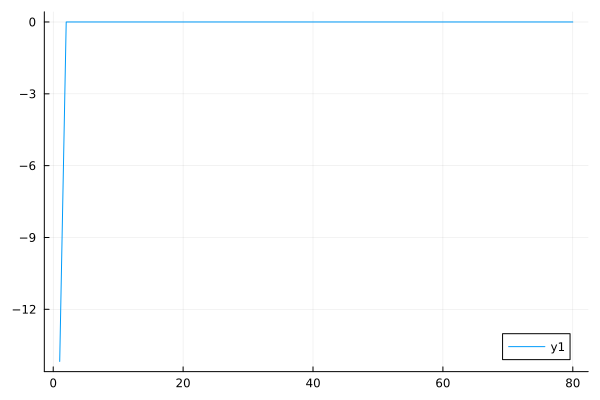

In [849]:
plot(Um[1,:])

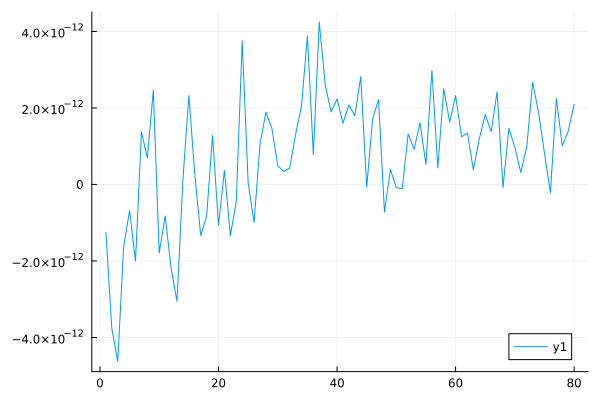

In [850]:
plot(Um[2,:])

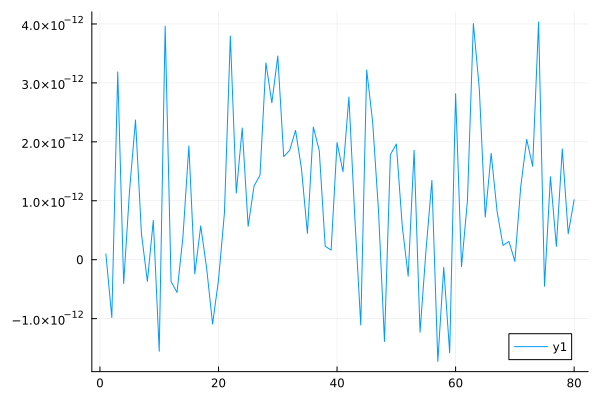

In [851]:
plot(Um[3,:])

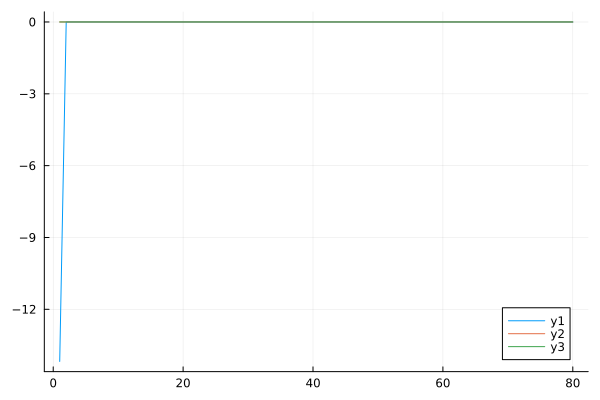

In [852]:
plot(Um[1,:])
plot!(Um[2,:])
plot!(Um[3,:])

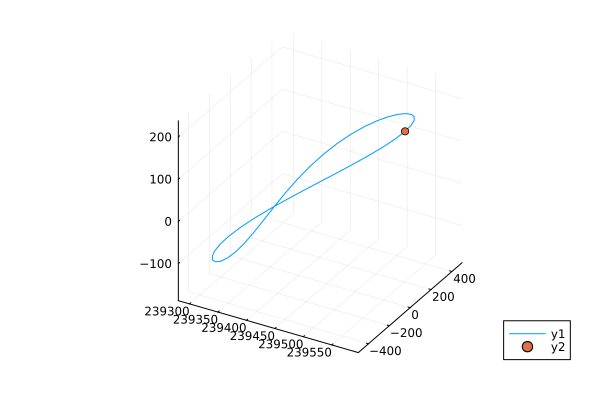

In [853]:
#check out the 1 period solve

#the x trajectory is generated using the linear dynamics
plot(final[1,1:41], final[2,1:41], final[3,1:41])
scatter!([final[1,1]], [final[2,1]], [final[3,1]])

In [854]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [855]:
#xtraj_test - reference_trajectory

In [856]:
#unstable_directions[:,2]

In [857]:
#norm(xtraj_test[:,41] - xtraj_test[:,1])

In [858]:
residual

6×80 Matrix{Float64}:
 -3.9814e-7    1.14297e-6  -1.70546e-6  …  0.00140833   0.00220741
  3.87183e-7  -3.54255e-7  -1.40545e-7     0.000798435  0.000891713
 -1.55329e-7   1.2894e-7    6.95857e-8     0.000594599  0.000861255
 -8.15369e-7   6.20185e-6  -1.14073e-5     1.16213      1.80489
 -2.28829e-9   9.13835e-7   2.86541e-6     0.579873     0.626146
 -2.67449e-7  -5.9455e-8   -2.31349e-6  …  0.472485     0.682441

In [859]:
#solve the problem again and pass in the residual as the bias in the dynamics constraint
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, residual, reference_trajectory2)
display("solving")
display(X)
Xm2, Um2 = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 133…669

([-0.0012847898760810494 -0.00117098186249957 … 11.898905110703373 14.108296355852314; 0.001846615782575271 0.0019158689521748577 … -3.5424750690541327 -4.531350252100205; … ; 0.0335958823634428 0.01810032037086527 … -319.016399597191 -421.68420430254633; 0.1046367901145706 0.030607672196162634 … 119.04641236151888 150.38145888137888], [-14.178000530629644 -1.3423523698843962e-11 … -1.6651207946335837e-12 -1.896110647987152e-12; -3.811851355915285e-12 -5.009299414413385e-12 … -2.979730372617562e-12 -1.05007468738977e-12; -4.713494718061363e-12 -2.6997597331595766e-12 … -5.44752691061554e-13 1.5558424736659764e-12])

In [860]:
half_rev_control = Um2[1:3, 1:21]/acceleration_scale

3×21 Matrix{Float64}:
 -7.21452e-8   -6.8306e-20   -7.45839e-20  …  -4.58337e-21   1.31871e-20
 -1.93967e-20  -2.549e-20    -5.29737e-21      2.55046e-22   2.34367e-21
 -2.39848e-20  -1.37378e-20   1.76128e-21      3.94922e-22  -4.72436e-21

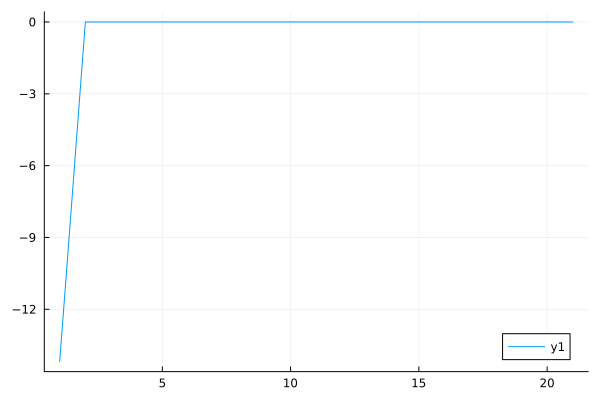

In [862]:
plot(Um2[1,1:21])

In [863]:
Um2[:,1]

3-element Vector{Float64}:
 -14.178000530629644
  -3.811851355915285e-12
  -4.713494718061363e-12

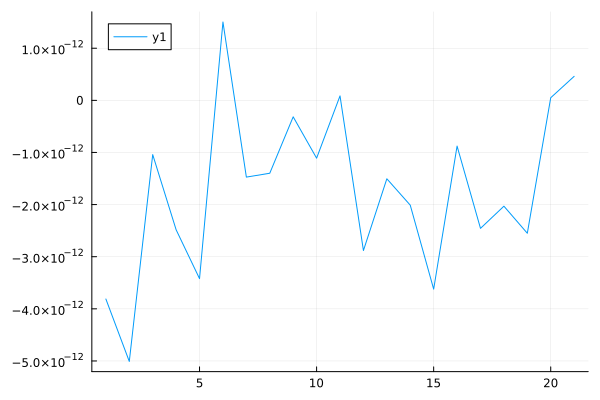

In [864]:
plot(Um2[2,1:21])

In [865]:
#plot(Um2[2,30:40])

In [866]:
#Um2[2, 32]

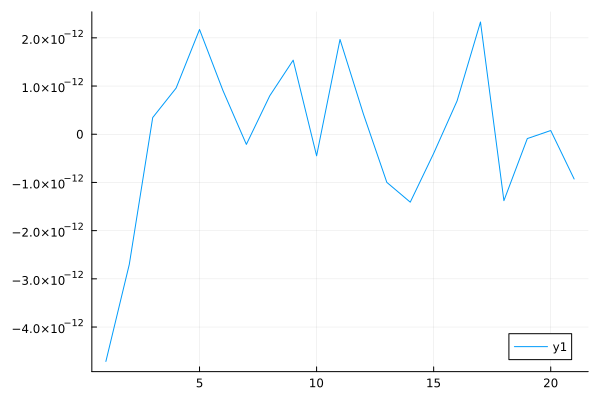

In [867]:
plot(Um2[3,1:21])

In [868]:
#for one period 40 controls
# xtraj_test2 = integrate_oneperiod(Xm2[:,1] + reference_trajectory[:,1], Um2[:,1:40])

In [869]:
# plot(xtraj_test2[1,:], xtraj_test2[2,:], xtraj_test2[3,:])
#scatter!([xtraj_test2[1,1]], [xtraj_test2[2,1]], [xtraj_test2[3,1]])

In [870]:
# xtraj_test2[:,1]

In [871]:
# xtraj_test2[:,41]

In [872]:
#similar to the first solve. No point in doing a second correction
#norm(xtraj_test2[:,1] - xtraj_test2[:,41])

In [873]:
#norm(xtraj_test2[:,41] - reference_trajectory[:,41])

In [874]:
#reference_trajectory[:,41]

In [875]:
#find if the updated solution satisfies the constraints
#delta_test2 = xtraj_test2 - reference_trajectory

In [876]:
#end_state = xtraj_test2[:,21]

#end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


#end_state_traj = get_state(end_state_sim)

In [877]:
#plot(end_state_traj[1,:],end_state_traj[2,:])
#scatter!([end_state_traj[1,1]],[end_state_traj[2,1]])

In [878]:
# constraint_satisfied_ndynamics2 = zeros(41)

# for i=1:41
#     constraint_satisfied_ndynamics2[i] = dot(delta_test2[:,i], unstable_directions[:,i])
# end

In [879]:
# plot(constraint_satisfied_ndynamics2 .>0)

In [880]:
#fixed the reference trajectory and added some slack on the halfspace constraint and it seems like I don't need to use the second order correction
#anymore

In [881]:
#this initial condition is working
#x_initial_ref = [1e-4, 0, 0, 0, 1e-4, 0]

#x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]


#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]

In [882]:
# xposedeviation = x_initial_ref[1] * L*1e3 #in meters

# vyposedeviation = x_initial_ref[5]*V_*1e3 #in m/s

# display(xposedeviation)
# display(vyposedeviation)

In [883]:
#this is one set of jacobians. if starting from beginning 

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [884]:
all_Ad[:,:,21:end]

6×6×21 Array{Float64, 3}:
[:, :, 1] =
  1.0388         0.000783757   -0.0105826    …   0.000209714  -9.4323e-6
 -0.000352537    0.98403        0.000171031      0.0026617    -1.33541e-7
 -0.0105881     -0.000369314    0.983451        -8.59422e-7    0.00267174
 28.9603         0.860838      -7.84476          0.15794      -0.0104437
 -0.404248     -11.7881         0.192683         0.972482     -0.000188587
 -7.85198       -0.405432     -12.26         …  -0.00125416    0.983483

[:, :, 2] =
  1.03766       0.00536305   -0.00989336   …   0.000213654  -8.6761e-6
  0.00423182    0.984991     -0.000853585      0.00266297   -1.01534e-6
 -0.0098435    -0.00136167    0.983609        -1.68035e-6    0.00267191
 28.0112        4.20497      -7.25167          0.16217      -0.00949086
  2.94485     -11.0067       -0.549612         0.974074     -0.00112456
 -7.19701      -1.10888     -12.1213       …  -0.0020912     0.983705

[:, :, 3] =
  1.03523      0.00900594   -0.00850522  …   0.000216617  -7.34292

In [885]:
all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,2:21], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,2:21], dims=3)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  3.62493e-6    1.86991e-7   -6.2941e-9
 -1.84078e-7    3.5922e-6    -3.32981e-10
 -6.2941e-9    -3.32981e-10   3.59893e-6
  0.00271006    0.000210717  -9.25814e-6
 -0.000204372   0.00266203   -3.63906e-7
 -9.20222e-6   -1.07637e-6    0.00267176

[:, :, 2] =
  3.62396e-6    1.89632e-7   -5.76703e-9
 -1.81438e-7    3.59305e-6   -8.99467e-10
 -5.76703e-9   -8.99467e-10   3.59905e-6
  0.00270834    0.00021441   -8.34475e-6
 -0.000200661   0.00266353   -1.16153e-6
 -8.22965e-6   -1.80105e-6    0.00267198

[:, :, 3] =
  3.6223e-6     1.91624e-7   -4.86421e-9
 -1.79446e-7    3.59448e-6   -1.22962e-9
 -4.86421e-9   -1.22962e-9    3.59928e-6
  0.00270574    0.000217063  -6.93566e-6
 -0.000197978   0.00266573   -1.60441e-6
 -6.79041e-6   -2.1338e-6     0.00267237

;;; … 

[:, :, 39] =
  3.62397e-6   1.81452e-7   -5.77011e-9
 -1.89617e-7   3.59305e-6    8.96714e-10
 -5.77011e-9   8.96714e-10   3.59905e-6
  0.00270935   0.000202413  -8.79598e-6
 -0.000212669 

In [886]:
all_Ad_2 = cat(all_Ad_half, all_Ad_half[:,:,2:end], dims = 3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  3.62493e-6    1.86991e-7   -6.2941e-9
 -1.84078e-7    3.5922e-6    -3.32981e-10
 -6.2941e-9    -3.32981e-10   3.59893e-6
  0.00271006    0.000210717  -9.25814e-6
 -0.000204372   0.00266203   -3.63906e-7
 -9.20222e-6   -1.07637e-6    0.00267176

[:, :, 2] =
  3.62396e-6    1.89632e-7   -5.76703e-9
 -1.81438e-7    3.59305e-6   -8.99467e-10
 -5.76703e-9   -8.99467e-10   3.59905e-6
  0.00270834    0.00021441   -8.34475e-6
 -0.000200661   0.00266353   -1.16153e-6
 -8.22965e-6   -1.80105e-6    0.00267198

[:, :, 3] =
  3.6223e-6     1.91624e-7   -4.86421e-9
 -1.79446e-7    3.59448e-6   -1.22962e-9
 -4.86421e-9   -1.22962e-9    3.59928e-6
  0.00270574    0.000217063  -6.93566e-6
 -0.000197978   0.00266573   -1.60441e-6
 -6.79041e-6   -2.1338e-6     0.00267237

;;; … 

[:, :, 79] =
  3.62397e-6   1.81452e-7   -5.77011e-9
 -1.89617e-7   3.59305e-6    8.96714e-10
 -5.77011e-9   8.96714e-10   3.59905e-6
  0.00270935   0.000202413  -8.79598e-6
 -0.000212669 

In [887]:
#another set of jacobians if starting from half

#all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,1:20], dims=3)
#all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,1:20], dims=3)

#all_Ad_2 = cat(all_Ad_half, all_Ad_half, dims=3)
#all_Bd_2 = cat(all_Bd_half, all_Bd_half, dims=3)

#All Ad1 is if you start from the beginning (2 orbits worth of jacobians) and all_Ad_2 is if you start from the half (2 orbits worth of jacobians).
#need to also have two sets of cost to go and unstable direction matrices that we pass in in the update_prob function 

In [888]:
#unstable directions is good. Need to fix V_2orbits
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,2:21], dims=2)

#P is for the 16 orbits. Need the one for just 1 orbit
V_half = cat(V[:,:,21:end], V[:,:,2:21], dims=3)


#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half[:,2:end], dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
  5.88733e11  -1.28569e10  -9.65603e10   4.1796e9    3.90156e9  -4.58643e8
 -1.28569e10   2.80771e8    2.1087e9    -9.1275e7   -8.5203e7    1.00159e7
 -9.65603e10   2.1087e9     1.58372e10  -6.85512e8  -6.39909e8   7.52237e7
  4.1796e9    -9.1275e7    -6.85512e8    2.96723e7   2.76984e7  -3.25605e6
  3.90156e9   -8.5203e7    -6.39909e8    2.76984e7   2.58558e7  -3.03944e6
 -4.58643e8    1.00159e7    7.52237e7   -3.25605e6  -3.03944e6   3.57299e5

[:, :, 2] =
  5.68365e11   2.78255e10  -8.43825e10   3.97865e9   3.97347e9  -2.82431e8
  2.78255e10   1.36226e9   -4.13112e9    1.94783e8   1.9453e8   -1.3827e7
 -8.43825e10  -4.13112e9    1.25279e10  -5.90691e8  -5.89921e8   4.19312e7
  3.97865e9    1.94783e8   -5.90691e8    2.78512e7   2.78149e7  -1.97707e6
  3.97347e9    1.9453e8    -5.89921e8    2.78149e7   2.77787e7  -1.97449e6
 -2.82431e8   -1.3827e7     4.19312e7   -1.97707e6  -1.97449e6   1.40347e5

[:, :, 3] =
  5.34245e11   5.8157e10  -6.76034e10

In [889]:
x_initial_ref_scaled

6-element Vector{Float64}:
 -0.0012847898760810494
  0.001846615782575271
  0.011444266626313038
  0.05302767708961436
  0.0335958823634428
  0.1046367901145706

In [890]:
unstable_directions_2[:,1]

6-element Vector{Float64}:
 -0.014154755627771133
  0.0045804331963484905
 -0.0009493005547567748
 -0.8925696587902248
  0.42532071609297856
 -0.1489948120659455

In [891]:
#pseudo code

orbit_count = 0
orbits = true

#number of orbits you want to plan go for
orbit_num = 100

halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)

solution_xm = zeros(6, 81, halforbit_num)
solution_um = zeros(6, 80, halforbit_num)

#optimal_Δx[:,1] = x_initial_ref


#while orbits
    
#    orbits=false
    
#for i=1:N_period-1
 
#i is now the number of times it orbits
for i=1:halforbit_num

        
    #Ad_k = cat(all_Ad_3p[:,:,i:end],all_Ad_3p[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd_3p[:,:,i:end],all_Bd_3p[:,:,1:(i-1)], dims=3)
    
    #Ad_k = cat(all_Ad[:,:,i:end],all_Ad[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd[:,:,i:end],all_Bd[:,:,1:(i-1)], dims=3)
    
    #Ad_k = all_Ad_3p[:,:,1:N_h]
    #Bd_k = all_Bd_3p[:,:,1:N_h]
      
    #horizon is two orbits ahead
    #all_Ad_k = cat(Ad_k, Ad_k, dims=3)
    #all_Bd_k = cat(Bd_k, Bd_k, dims=3)
        
    #cons, X, U = update_prob(optimal_Δx[:,i], all_Ad_k, all_Bd_k)
    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1 
        reference_traj_k = reference_trajectory2       
    else
        #println("using jacobian 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
        reference_traj_k = reference_trajectory2_2
    end
    Δt
    #the zeros is the bias 
    cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, zeros(6, N_h-1), reference_traj_k)
        
    Xm, Um = solve_opt(cons, X, U,N_h)

    solution_xm = Xm
    solution_um = Um
    
    #get the optimal controls for half a period (20 for this example)
        
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    if i%2 != 0
        
        #print("from beginning")
        
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #print("this is reference trajectory at half: ", reference_trajectory[:,21])
        #println("from half")
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    #println("this is the initial condition for the next rev: ", x_initial_ref)
    
end  

Half Revolution solved: 1
Half Revolution solved: 2
Half Revolution solved: 3
Half Revolution solved: 4
Half Revolution solved: 5
Half Revolution solved: 6
Half Revolution solved: 7
Half Revolution solved: 8
Half Revolution solved: 9
Half Revolution solved: 10
Half Revolution solved: 11
Half Revolution solved: 12
Half Revolution solved: 13
Half Revolution solved: 14
Half Revolution solved: 15
Half Revolution solved: 16
Half Revolution solved: 17
Half Revolution solved: 18
Half Revolution solved: 19
Half Revolution solved: 20
Half Revolution solved: 21
Half Revolution solved: 22
Half Revolution solved: 23
Half Revolution solved: 24
Half Revolution solved: 25
Half Revolution solved: 26
Half Revolution solved: 27
Half Revolution solved: 28
Half Revolution solved: 29
Half Revolution solved: 30
Half Revolution solved: 31
Half Revolution solved: 32
Half Revolution solved: 33
Half Revolution solved: 34
Half Revolution solved: 35
Half Revolution solved: 36
Half Revolution solved: 37
Half Revol

In [892]:
#the current problem is that the linear problem does satisfy the dynamics, however, the nonlinear rollout breaks those dynamics. need second order
# correction for the MPC problem. FIXED 

In [893]:
all_optimal_Δx

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 -0.00128479  -0.0011706   -0.00106633  …  -0.00138644  -0.00144699
  0.00184662   0.00191561   0.00194332     -0.00140512  -0.00133617
  0.0114443    0.0116262    0.0116079      -0.00807809  -0.00865817
  0.0530277    0.0316049    0.04548        -0.0295082   -0.00262044
  0.0335959    0.0180998    0.00199271      0.015645     0.0292529
  0.104637     0.0306082   -0.0443011   …  -0.281806    -0.165465

[:, :, 2] =
 -0.00144699  -0.00147693  -0.00148843  …  -0.0013209    -0.0013078
 -0.00133617  -0.00123742  -0.00109292      0.000380342   0.000438405
 -0.00865817  -0.00893634  -0.00889184      0.010405      0.0108627
 -0.00262044  -0.0175219    0.00811546      0.00300188    0.0159658
  0.0292529    0.045808     0.0612128       0.0229677     0.0210625
 -0.165465    -0.0444737    0.0765912   …   0.20604       0.137433

[:, :, 3] =
 -0.0013078    -0.0012853    -0.00126571   …  -0.00144212   -0.00149367
  0.000438405   0.000489582   0.000530229     -0

In [894]:
dot(all_optimal_Δx[:,end,1], unstable_directions_2[:,21])

-0.019031945249749403

In [895]:
dot(all_optimal_Δx[:,end,2], unstable_directions_2[:,1])

-0.02575875368463164

In [896]:
#dot(acceleration_scale[:,end,2], unstable_directions_2_2[:,21])

In [897]:
solution_xm

6×81 Matrix{Float64}:
 -0.00186486  -0.00208107  -0.00231742  …     7.52005      9.48883
 -0.0139034   -0.0135075   -0.0126629        -7.52237     -8.86973
 -0.00993904  -0.0108741   -0.0113854        -0.542003    -1.05086
 -0.0690407   -0.0912613   -0.0891137       643.185      828.214
  0.0603629    0.234269     0.390256       -484.447     -515.55
 -0.4229      -0.272929    -0.106423    …  -160.096     -219.706

In [898]:
unstable_directions_2_2

6×81 Matrix{Float64}:
 -0.00948995  -0.00996026  -0.0105469   …  -0.00916181   -0.00948995
  0.00885875   0.00851811   0.00812971      0.00914996    0.00885875
  0.00104137   0.00142293   0.00177742      0.000650366   0.00104137
 -0.828211    -0.868446    -0.902084       -0.783552     -0.828211
  0.515586     0.436984     0.360496        0.590017      0.515586
  0.219246     0.233824     0.236869    …   0.194315      0.219246

In [899]:
xtraj_halfperiod_test = integrate_halfperiod(reference_trajectory[:,21] + solution_xm[:,1], optimal_u)

6×21 Matrix{Float64}:
     2.39289e5      2.3929e5  …       2.39585e5       2.39588e5
    -0.0139035     80.0617           70.7219          0.011535
  -175.737       -172.402           224.152         226.181
    -0.0690222    540.968          1829.34            0.311111
 29978.9        29460.3          -26119.6        -26419.7
    -0.422915    2469.58      …    1508.39            0.270699

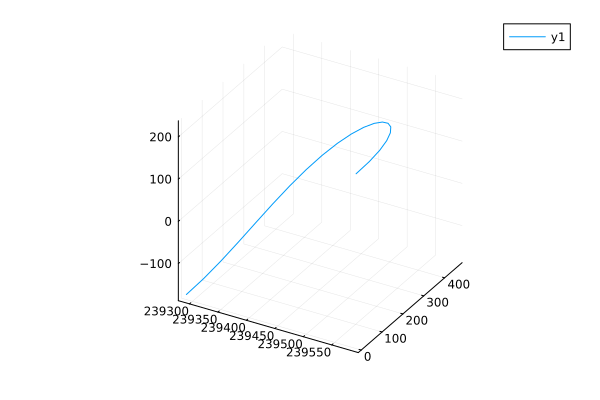

In [901]:
plot(xtraj_halfperiod_test[1,:],xtraj_halfperiod_test[2,:], xtraj_halfperiod_test[3,:])

In [902]:
test_deltas = xtraj_halfperiod_test - reference_trajectory[:,21:end]

6×21 Matrix{Float64}:
 -0.00186486  -0.00207873  -0.00231701  …  -0.0023345  -0.00153507
 -0.0139034   -0.0135075   -0.0126627       0.0113666   0.011535
 -0.00993904  -0.0108742   -0.0113854       0.0120349   0.012867
 -0.0690407   -0.0912555   -0.0890958       0.291334    0.311116
  0.0603629    0.234265     0.390251        0.111195    0.0147006
 -0.4229      -0.272927    -0.10642     …   0.351107    0.2707

In [903]:
test_deltas - solution_xm[:,1:21]

6×21 Matrix{Float64}:
 0.0   2.33717e-6   4.14175e-7  -5.06146e-7  …   6.61276e-6    7.87998e-6
 0.0  -3.77382e-8   1.71985e-7   1.2886e-7      -2.13289e-6   -2.77386e-6
 0.0  -1.15255e-7  -2.50178e-8   1.77437e-8      8.62665e-7    1.01357e-6
 0.0   5.84786e-6   1.79265e-5   3.05842e-5      0.000414972   0.000489941
 0.0  -4.22344e-6  -5.50004e-6  -5.05064e-6     -0.000211113  -0.000266949
 0.0   1.81731e-6   3.66688e-6   6.61772e-6  …   4.70904e-5    6.15948e-5

In [904]:
#linear problem is good
solution_xm[:, 1:21]

6×21 Matrix{Float64}:
 -0.00186486  -0.00208107  -0.00231742  …  -0.00234111  -0.00154295
 -0.0139034   -0.0135075   -0.0126629       0.0113688    0.0115378
 -0.00993904  -0.0108741   -0.0113854       0.0120341    0.012866
 -0.0690407   -0.0912613   -0.0891137       0.290919     0.310626
  0.0603629    0.234269     0.390256        0.111406     0.0149675
 -0.4229      -0.272929    -0.106423    …   0.35106      0.270638

In [905]:
#linear problem is good and solves
test = zeros(21)

for k=1:21
    test[k] = dot(test_deltas[:,k], unstable_directions_2_2[:,k])

end


In [906]:
test

21-element Vector{Float64}:
 -0.004532501465822129
  0.1176934571897443
  0.19574955659756335
  0.26031917563353085
  0.3043080445236652
  0.3262316726590112
  0.32869418002264017
  0.3136152008694496
  0.2842125642730276
  0.24505452291575439
  ⋮
  0.0932797383782506
  0.03715500161554873
 -0.020160052035540665
 -0.07749092267212089
 -0.13061108014758974
 -0.18004118735357522
 -0.22704241070238151
 -0.27188096818847196
 -0.31171094318187365

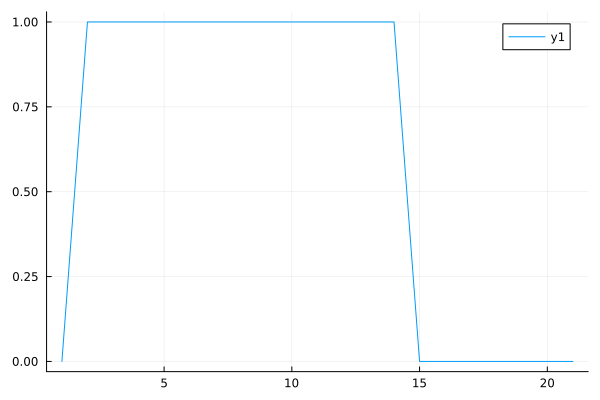

In [907]:
plot(test .>0)

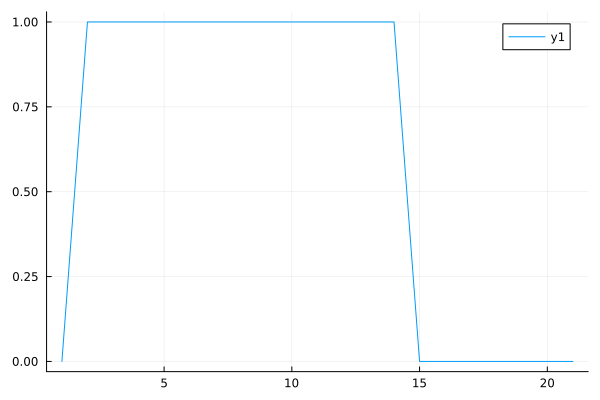

In [908]:
plot(test.>0)

In [910]:
rev1 = all_optimal_x[:,:,1]
rev2 = all_optimal_x[:,:,2]
rev3 = all_optimal_x[:,:,3]
rev4 = all_optimal_x[:,:,4]
rev5 = all_optimal_x[:,:,5]
# rev20 = all_optimal_x[:,:,20]

# rev59 = all_optimal_x[:,:,59]
# rev60 = all_optimal_x[:,:,60]
#rev25 = all_optimal_x[:,:,25]

6×21 Matrix{Float64}:
      2.39588e5         2.39585e5  …      2.3929e5      2.39289e5
     -0.000711875     -70.7113          -80.0743        0.00111526
    226.178           224.15           -172.398      -175.734
     -0.0173388     -1829.08           -541.081        -0.000346944
 -26419.7          -26119.7           29460.1       29978.9
      0.164441      -1507.94       …  -2470.17         -0.21697

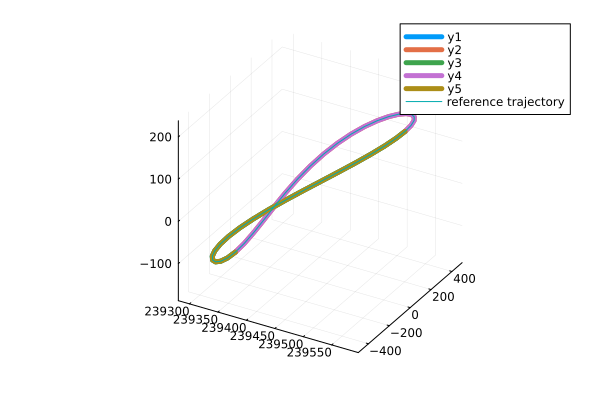

In [911]:
plot(rev1[1,:], rev1[2,:], rev1[3,:], lw=5)
#scatter!([rev1[1,1]],[rev1[2,1]],[rev1[3,1]], lw=5)
plot!(rev2[1,:], rev2[2,:], rev2[3,:], lw=5)
plot!(rev3[1,:], rev3[2,:], rev3[3,:], lw=5)
plot!(rev4[1,:], rev4[2,:], rev4[3,:], lw=5)
plot!(rev5[1,:], rev5[2,:], rev5[3,:], lw=5)
#plot!(rev59[1,:], rev59[2,:], rev59[3,:], lw=5)
#plot!(rev60[1,:], rev60[2,:], rev60[3,:], lw=5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="reference trajectory")

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

In [912]:
1e-3*L

238.529

In [913]:
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [914]:
#have orbit_num trajectories of N knot points

for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [915]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
      2.39588e5        2.39585e5  …      2.3929e5      2.39289e5
      0.00184662     -70.7087          -80.0766       -0.00133628
    226.18           224.152          -172.399      -175.735
      0.0530277    -1829.01           -541.092        -0.00260194
 -26419.7         -26119.7           29460.0       29978.9
      0.104637     -1508.01       …  -2470.14         -0.165479

[:, :, 2] =
     2.39289e5       2.3929e5  …       2.39585e5       2.39588e5
    -0.00133628     80.074            70.711           0.00043843
  -175.735        -172.4             224.15          226.179
    -0.00260194    541.042          1829.05            0.0159609
 29978.9         29460.1          -26119.7        -26419.7
    -0.165479     2469.81      …    1508.24            0.137432

[:, :, 3] =
      2.39588e5         2.39585e5  …      2.3929e5      2.39289e5
      0.000438405     -70.7101          -80.0753        1.88416e-5
    226.179           224.151          -

In [916]:
all_optimal_x_formatted

6×41×100 Array{Float64, 3}:
[:, :, 1] =
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
      0.00184662     -70.7087            70.711           0.00043843
    226.18           224.152            224.15          226.179
      0.0530277    -1829.01            1829.05            0.0159609
 -26419.7         -26119.7           -26119.7        -26419.7
      0.104637     -1508.01       …    1508.24            0.137432

[:, :, 2] =
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      0.000438405     -70.7101            70.7099         -0.00071185
    226.179           224.151            224.149         226.178
      0.0159658     -1829.04            1829.02           -0.0173436
 -26419.7          -26119.7           -26119.7        -26419.7
      0.137433      -1507.97       …    1508.26            0.16444

[:, :, 3] =
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
     -0.000711875     -70.7113            70.7091         -0.001

In [917]:
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))
#all_xtraj = reshape(all_optimal_x, (6, 210))

6×4100 Matrix{Float64}:
 -0.00128479  -0.0011706   -0.00106633  …  -0.0023345  -0.00153507
  0.00184662   0.00191561   0.00194332      0.0113666   0.011535
  0.0114443    0.0116262    0.0116079       0.0120349   0.012867
  0.0530277    0.0316049    0.04548         0.291334    0.311116
  0.0335959    0.0180998    0.00199271      0.111195    0.0147006
  0.104637     0.0306082   -0.0443011   …   0.351107    0.2707

In [918]:
normz = zeros(4100)

4100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [919]:
for i=1:4100
    normz[i] = norm(all_Δxtraj[:,i])
end

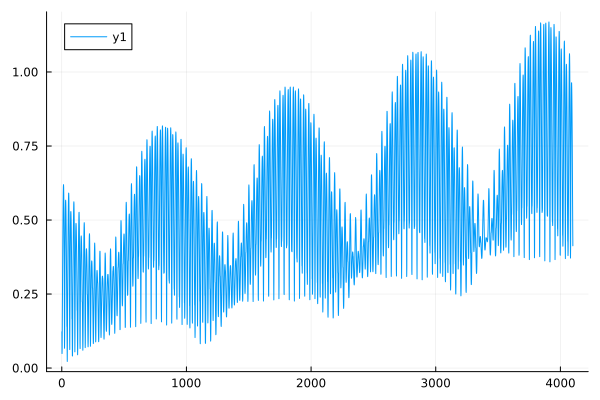

In [920]:
plot(normz )

In [921]:
all_xtraj 

6×4100 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
      0.00184662     -70.7087            70.7219          0.011535
    226.18           224.152            224.152         226.181
      0.0530277    -1829.01            1829.34            0.311111
 -26419.7         -26119.7           -26119.6        -26419.7
      0.104637     -1508.01       …    1508.39            0.270699

In [922]:
for i=1:100
    deltaxsub = all_Δxtraj[41*(i-1)+1:41*i]

    for i=1:41
        plot(deltaxsub[1,:], deltaxsub[2,:], deltaxsub[3,:], lw=5)
    end
end

In [923]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -14.1767       -2.54184e-12   2.0522e-13   …  -1.6214e-12    3.47892e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      1.27786e-12  -1.06665e-12
   9.95262e-14  -9.80982e-13   3.18536e-12     -1.09151e-12  -3.44787e-13

[:, :, 2] =
 -16.7957        2.95021e-13  -3.10039e-12  …  -9.46652e-13  8.50557e-13
  -1.64263e-11   2.18412e-13  -3.05176e-12     -1.99421e-12  1.17003e-12
  -1.20264e-12  -8.27175e-13   5.39718e-13     -2.03913e-12  1.71897e-12

[:, :, 3] =
 -10.7814       -6.50689e-12  -5.67929e-12  …   1.14314e-12   3.61734e-13
  -2.13654e-12  -1.88047e-12  -7.46843e-13      5.36439e-13   2.56387e-13
  -1.55581e-12  -1.10004e-12  -8.37554e-13     -4.72217e-12  -8.25112e-13

;;; … 

[:, :, 198] =
 -16.9125       -1.00753e-12  -1.73317e-12  …  -3.75868e-13  -1.60685e-12
  -2.06711e-11  -5.46179e-13  -1.85176e-12     -5.4601e-13   -2.99473e-12
   8.23272e-13  -1.2446e-12   -2.89495e-13     -7.73979e-13  -1.19322e-12

[:, :, 199] =
 -11.2333  

In [924]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -14.1767       -2.54184e-12   2.0522e-13   …  -1.6214e-12    3.47892e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      1.27786e-12  -1.06665e-12
   9.95262e-14  -9.80982e-13   3.18536e-12     -1.09151e-12  -3.44787e-13

[:, :, 2] =
 -16.7957        2.95021e-13  -3.10039e-12  …  -9.46652e-13  8.50557e-13
  -1.64263e-11   2.18412e-13  -3.05176e-12     -1.99421e-12  1.17003e-12
  -1.20264e-12  -8.27175e-13   5.39718e-13     -2.03913e-12  1.71897e-12

[:, :, 3] =
 -10.7814       -6.50689e-12  -5.67929e-12  …   1.14314e-12   3.61734e-13
  -2.13654e-12  -1.88047e-12  -7.46843e-13      5.36439e-13   2.56387e-13
  -1.55581e-12  -1.10004e-12  -8.37554e-13     -4.72217e-12  -8.25112e-13

;;; … 

[:, :, 198] =
 -16.9125       -1.00753e-12  -1.73317e-12  …  -3.75868e-13  -1.60685e-12
  -2.06711e-11  -5.46179e-13  -1.85176e-12     -5.4601e-13   -2.99473e-12
   8.23272e-13  -1.2446e-12   -2.89495e-13     -7.73979e-13  -1.19322e-12

[:, :, 199] =
 -11.2333  

In [925]:
all_optimal_u 

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 -14.1767       -2.54184e-12   2.0522e-13   …  -1.6214e-12    3.47892e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      1.27786e-12  -1.06665e-12
   9.95262e-14  -9.80982e-13   3.18536e-12     -1.09151e-12  -3.44787e-13

[:, :, 2] =
 -16.7957        2.95021e-13  -3.10039e-12  …  -9.46652e-13  8.50557e-13
  -1.64263e-11   2.18412e-13  -3.05176e-12     -1.99421e-12  1.17003e-12
  -1.20264e-12  -8.27175e-13   5.39718e-13     -2.03913e-12  1.71897e-12

[:, :, 3] =
 -10.7814       -6.50689e-12  -5.67929e-12  …   1.14314e-12   3.61734e-13
  -2.13654e-12  -1.88047e-12  -7.46843e-13      5.36439e-13   2.56387e-13
  -1.55581e-12  -1.10004e-12  -8.37554e-13     -4.72217e-12  -8.25112e-13

;;; … 

[:, :, 198] =
 -16.9125       -1.00753e-12  -1.73317e-12  …  -3.75868e-13  -1.60685e-12
  -2.06711e-11  -5.46179e-13  -1.85176e-12     -5.4601e-13   -2.99473e-12
   8.23272e-13  -1.2446e-12   -2.89495e-13     -7.73979e-13  -1.19322e-12

[:, :, 199] =
 -11.2333  

In [926]:
all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

3×4000 Matrix{Float64}:
 -14.1767       -2.54184e-12   2.0522e-13   …  -5.26659e-13  -1.11212e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      5.21587e-13  -7.52444e-13
   9.95262e-14  -9.80982e-13   3.18536e-12      8.24063e-14   2.70754e-13

In [927]:
all_utraj

3×4000 Matrix{Float64}:
 -14.1767       -2.54184e-12   2.0522e-13   …  -5.26659e-13  -1.11212e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      5.21587e-13  -7.52444e-13
   9.95262e-14  -9.80982e-13   3.18536e-12      8.24063e-14   2.70754e-13

In [928]:
all_utraj_scaled = all_utraj/acceleration_scale

3×4000 Matrix{Float64}:
 -7.21384e-8   -1.29342e-20   1.04427e-21  …  -2.67992e-21  -5.65907e-21
 -6.36376e-21  -1.91497e-20  -2.35368e-20      2.65411e-21  -3.82883e-21
  5.06442e-22  -4.99176e-21   1.62088e-20      4.19327e-22   1.37774e-21

In [929]:
#save all u traj scaled to a text file for the test simulation
#cr3bp units 
using DelimitedFiles

#writedlm("utraj.txt", all_utraj_scaled, ',')

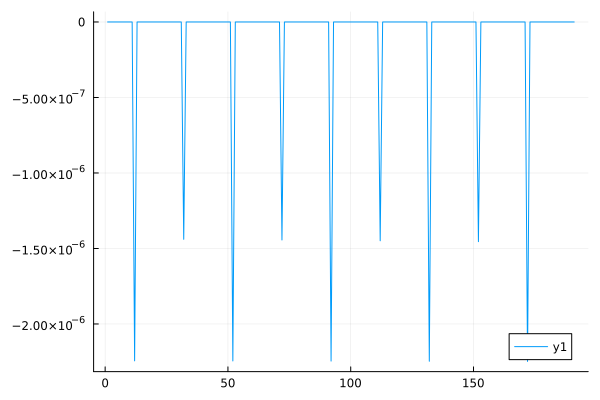

In [930]:
plot(all_utraj[1,410:600]*1e3/86400^2)

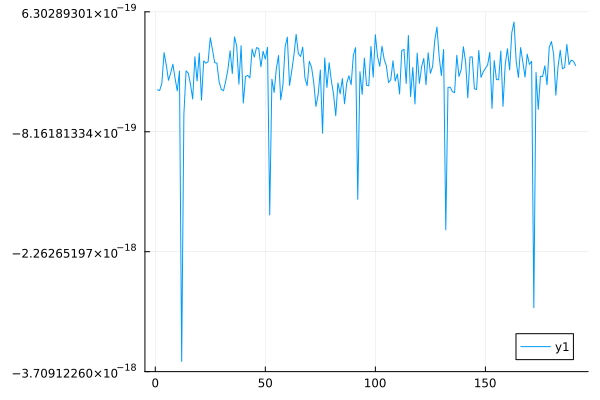

┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/faustovega/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191


In [931]:
plot(all_utraj[2,410:600]*1e3/86400^2)

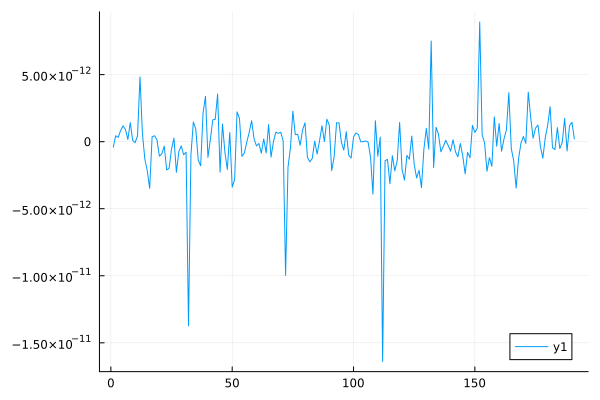

In [932]:
plot(all_utraj[3,410:600])

In [933]:
horizon 

41-element LinRange{Float64, Int64}:
 0.0, 0.00268661, 0.00537322, 0.00805982, …, 0.102091, 0.104778, 0.107464

In [934]:
Δt

0.002686608149766249

In [935]:
days_range = range(0,409, 410)

days = collect(days_range)*Δt

410-element Vector{Float64}:
 0.0
 0.002686608149766249
 0.005373216299532498
 0.008059824449298748
 0.010746432599064996
 0.013433040748831244
 0.016119648898597495
 0.018806257048363743
 0.02149286519812999
 0.02417947334789624
 ⋮
 1.0773298680562657
 1.080016476206032
 1.0827030843557983
 1.0853896925055646
 1.088076300655331
 1.090762908805097
 1.0934495169548633
 1.0961361251046295
 1.0988227332543958

In [936]:
days[41]

0.10746432599064995

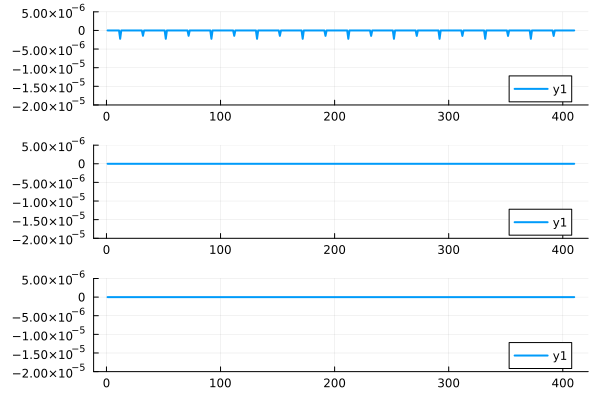

In [937]:
plot_range = (-2e-5, 5e-6)

plot1 = plot(all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range,xlabel="")
plot2 = plot(all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range)
plot3 = plot(all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range)


plot_layout = @layout [a;
                       b; 
                       c]

plot(plot1, plot2, plot3, layout=plot_layout)

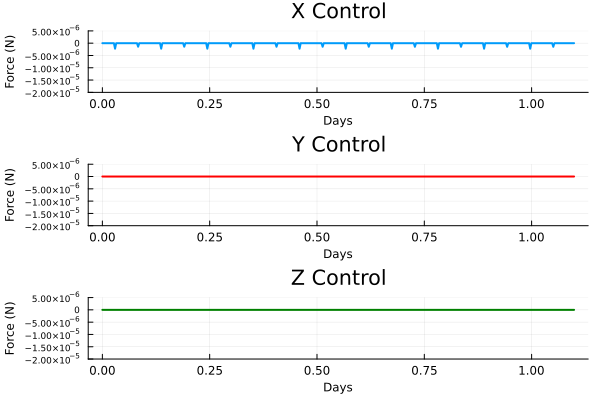

In [938]:
#this plots orbits 10-20

plot_range = (-2e-5, 5e-6)


plot1 = plot(days, all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range, title= "X Control")
plot2 = plot(days, all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range, title= "Y Control", linecolor="red")
plot3 = plot(days , all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range, title= "Z Control", linecolor="green")


plot_layout = @layout [a;
                       b; 
                       c]

control1020 = plot(plot1, plot2, plot3, layout=plot_layout, legend=false, xlabel="Days", xlabelfontsize=8, ylabel="Force (N)", ylabelfontsize=8, ytickfontsize = 6)

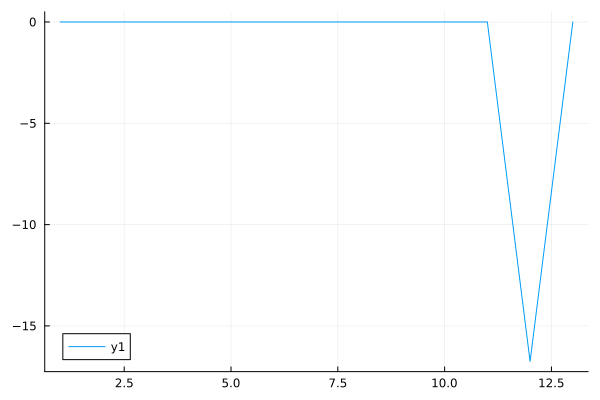

In [939]:
plot(all_utraj[1,410:422])

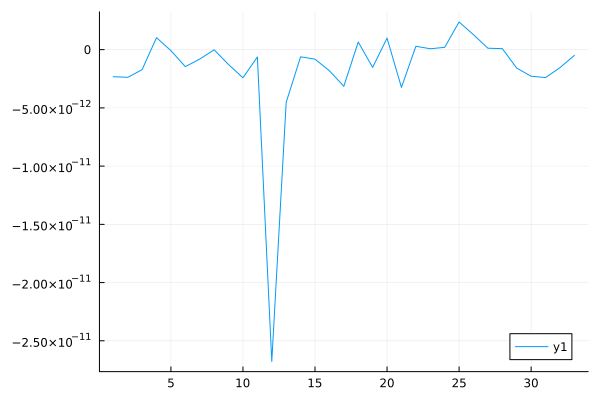

In [940]:
plot(all_utraj[2,410:442])

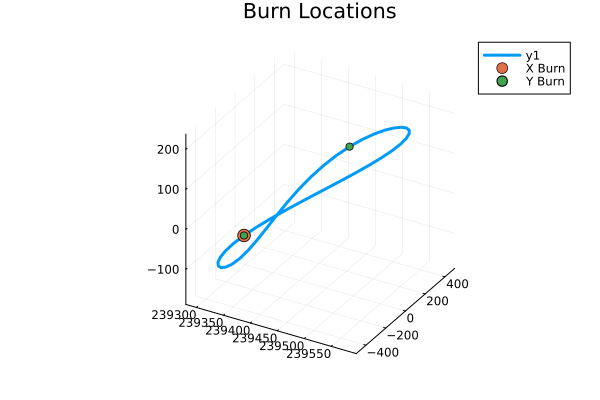

In [941]:
burn_locations = plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], linewidth = 3, title= "Burn Locations")
scatter!([reference_trajectory[1,12]],[reference_trajectory[2,12]],[reference_trajectory[3,12]], label="X Burn", markersize = 7)
scatter!([reference_trajectory[1,12], reference_trajectory[1,31]],[reference_trajectory[2,12], reference_trajectory[2,31]],[reference_trajectory[3,12], reference_trajectory[3,31]], label="Y Burn", markersize = 4)

In [942]:
#savefig( burn_locations, "burn_locations")

In [943]:
#savefig( control1020, "control1020")

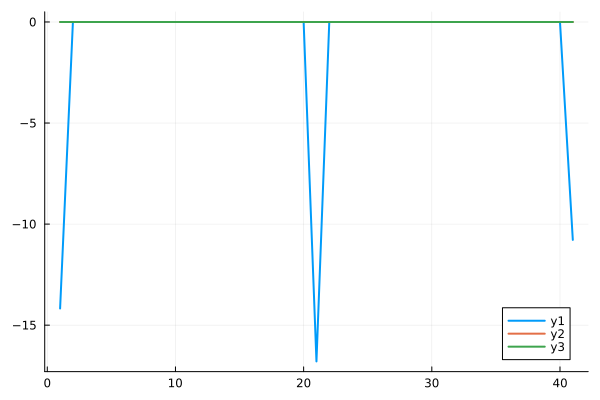

In [944]:
plot(all_utraj[1,1:41], linewidth = 2)
plot!(all_utraj[2,1:41], linewidth = 2)
plot!(all_utraj[3,1:41], linewidth=2)

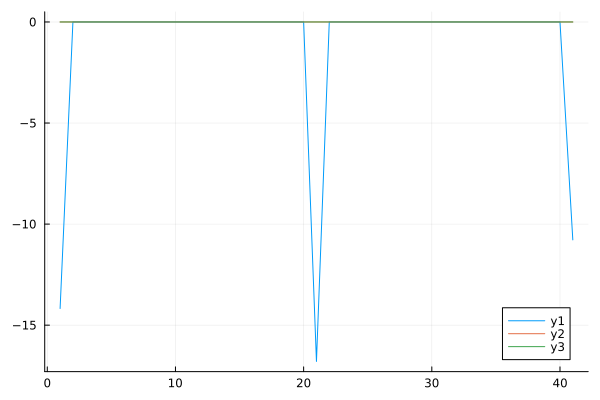

In [945]:
plot(all_utraj[1,1:41])
plot!(all_utraj[2,1:41])
plot!(all_utraj[3,1:41])

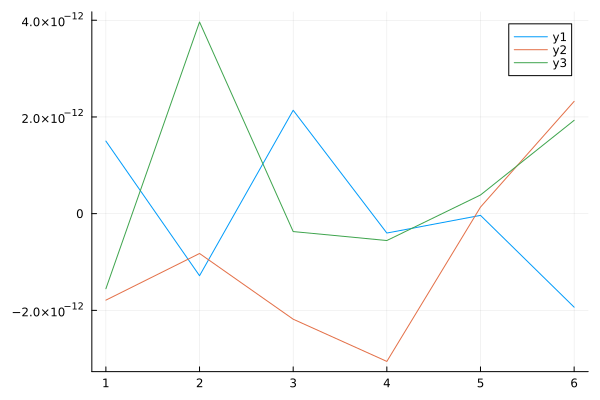

In [946]:
plot(all_utraj[1,10:15])
plot!(all_utraj[2,10:15])
plot!(all_utraj[3,10:15])

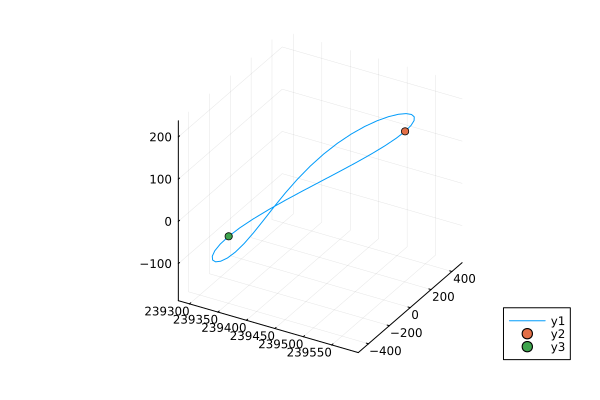

In [947]:
plot(all_xtraj[1,1:41], all_xtraj[2,1:41], all_xtraj[3,1:41])


scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]])
scatter!([all_xtraj[1,13]], [all_xtraj[2,13]], [all_xtraj[3,13]])

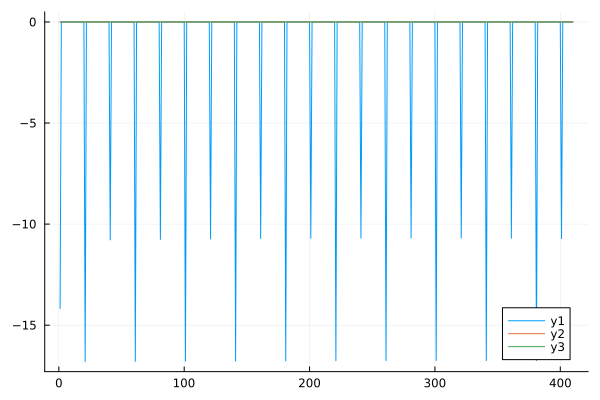

In [948]:
#this is for 5 orbits
plot(all_utraj[1,1:410])
plot!(all_utraj[2,1:410])
plot!(all_utraj[3,1:410])

In [949]:
# size(all_utraj)

In [951]:
one_orbit = all_utraj[:,41:80]

3×40 Matrix{Float64}:
 -10.7814       -6.50689e-12  -5.67929e-12  …  4.96339e-13  -1.49962e-12
  -2.13654e-12  -1.88047e-12  -7.46843e-13     9.62992e-13   9.81539e-13
  -1.55581e-12  -1.10004e-12  -8.37554e-13     5.72889e-13  -5.81768e-13

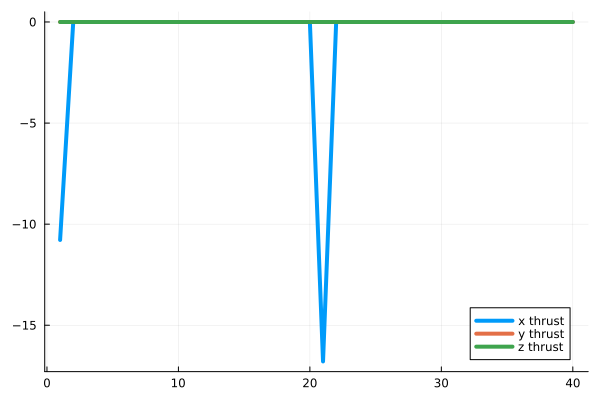

In [952]:
#the beginning thrust is to get it back on track since the initialization is off by 1e-3

plot(one_orbit[1,:], label="x thrust", linewidth=4)

plot!(one_orbit[2,:], label="y thrust", linewidth=4)

plot!(one_orbit[3,:], label="z thrust", linewidth=4)

In [953]:
#once we are at the orbit this is what it looks like
last_orbit = all_utraj[:,3961:end]

3×40 Matrix{Float64}:
 -11.2333       -7.38427e-12  -3.07914e-12  …  -5.26659e-13  -1.11212e-12
  -2.04269e-12   2.18565e-13   1.70311e-13      5.21587e-13  -7.52444e-13
  -1.18237e-12  -1.0063e-13   -9.36347e-13      8.24063e-14   2.70754e-13

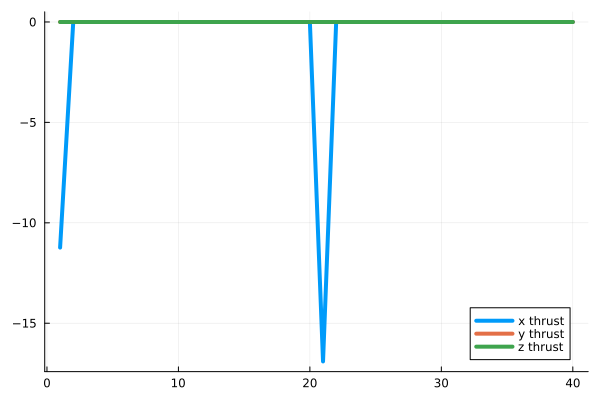

In [954]:
plot(last_orbit[1,:], label="x thrust", linewidth=4)

plot!(last_orbit[2,:], label="y thrust", linewidth=4)

plot!(last_orbit[3,:], label="z thrust", linewidth=4)

In [955]:
all_xtraj

6×4100 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
      0.00184662     -70.7087            70.7219          0.011535
    226.18           224.152            224.152         226.181
      0.0530277    -1829.01            1829.34            0.311111
 -26419.7         -26119.7           -26119.6        -26419.7
      0.104637     -1508.01       …    1508.39            0.270699

In [956]:
all_utraj 

3×4000 Matrix{Float64}:
 -14.1767       -2.54184e-12   2.0522e-13   …  -5.26659e-13  -1.11212e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      5.21587e-13  -7.52444e-13
   9.95262e-14  -9.80982e-13   3.18536e-12      8.24063e-14   2.70754e-13

In [957]:
norm(all_utraj[:,1])

14.176672110297362

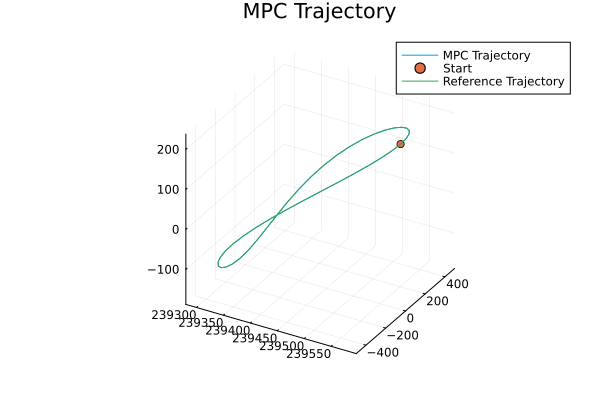

In [958]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

In [959]:
all_xtraj 

6×4100 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
      0.00184662     -70.7087            70.7219          0.011535
    226.18           224.152            224.152         226.181
      0.0530277    -1829.01            1829.34            0.311111
 -26419.7         -26119.7           -26119.6        -26419.7
      0.104637     -1508.01       …    1508.39            0.270699

In [960]:
all_xtraj

6×4100 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
      0.00184662     -70.7087            70.7219          0.011535
    226.18           224.152            224.152         226.181
      0.0530277    -1829.01            1829.34            0.311111
 -26419.7         -26119.7           -26119.6        -26419.7
      0.104637     -1508.01       …    1508.39            0.270699

In [961]:
all_xtraj[1:3,41]/L 

3-element Vector{Float64}:
 1.0044381443244539
 1.8380554272388385e-9
 0.0009482256059299826

In [962]:
all_xtraj[4:6,41]/V_ 

3-element Vector{Float64}:
  2.3312240805777734e-9
 -0.0038588130844814657
  2.0073015740038775e-8

In [963]:
all_xtraj

6×4100 Matrix{Float64}:
      2.39588e5        2.39585e5  …       2.39585e5       2.39588e5
      0.00184662     -70.7087            70.7219          0.011535
    226.18           224.152            224.152         226.181
      0.0530277    -1829.01            1829.34            0.311111
 -26419.7         -26119.7           -26119.6        -26419.7
      0.104637     -1508.01       …    1508.39            0.270699

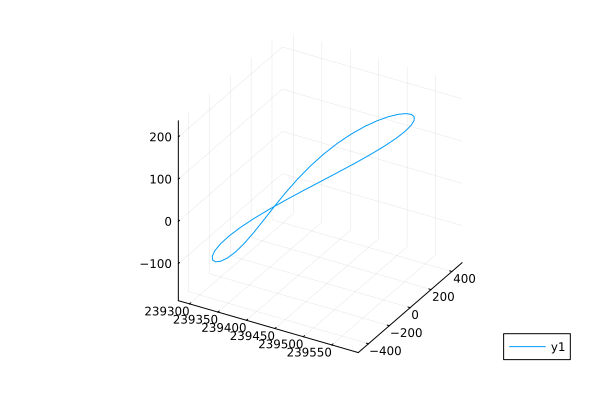

In [964]:
plot(all_xtraj[1, 1:41],all_xtraj[2, 1:41],all_xtraj[3, 1:41])

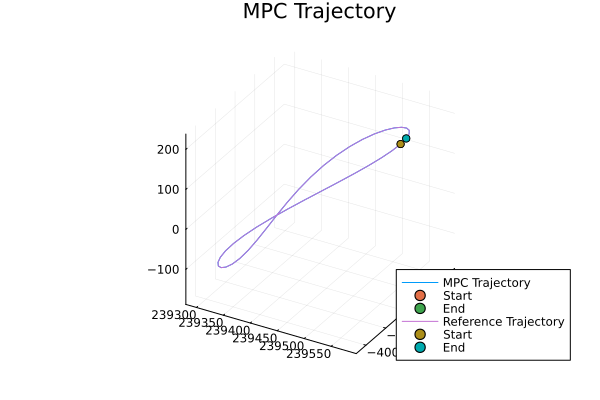

In [965]:
iter = 40

plot(all_xtraj[1,1:iter], all_xtraj[2,1:iter], all_xtraj[3,1:iter], label="MPC Trajectory", title="MPC Trajectory")
scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")
scatter!([all_xtraj[1,iter]], [all_xtraj[2,iter]], [all_xtraj[3,iter]], label="End")
plot!(reference_trajectory[1,1:iter], reference_trajectory[2,1:iter], reference_trajectory[3,1:iter], label = "Reference Trajectory")
scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]], label="Start")
scatter!([reference_trajectory[1,iter]], [reference_trajectory[2,iter]], [reference_trajectory[3,iter]], label="End")


In [966]:
#plot the final orbit
size(all_xtraj)

(6, 4100)

In [967]:
#i = 50
#plot(all_xtraj[1,40*(i-1)+1:40*i], all_xtraj[2,40*(i-1)+1:40*i], all_xtraj[3,40*(i-1)+1:40*i], label="MPC Trajectory", title="MPC Trajectory",lw=3)


#plot!(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory",lw=3)
#plot!(all_xtraj[1,81:120], all_xtraj[2,81:120], all_xtraj[3,81:120], label="MPC Trajectory", title="MPC Trajectory",lw=3)



#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3)


#plot(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory", lw=3)
#plot(all_xtraj[1,81:end], all_xtraj[2,81:end], all_xtraj[3,81:end], label="MPC Trajectory", title="MPC Trajectory", lw=3)

#scatter!([all_xtraj[1,1]],[all_xtraj[2,1]], [all_xtraj[3,1]], label="1")

#scatter!([all_xtraj[1,40]],[all_xtraj[2,40]], [all_xtraj[3,40]], label="40")

#scatter!([all_xtraj[1,41]],[all_xtraj[2,41]], [all_xtraj[3,41]], label="41")

#scatter!([all_xtraj[1,81]],[all_xtraj[2,81]], [all_xtraj[3,81]], label="80")

In [968]:
#plot(optimal_u[1,:].*acceleration_scale)

In [969]:
#plot(optimal_u[2,:])

In [970]:
#plot(optimal_u[3,:])

In [971]:
#acceleration_scale

In [972]:
#scaled_control.*acceleration_scale

In [973]:
#all_utraj

In [974]:
all_xtraj[:,21]

6-element Vector{Float64}:
 239289.34435892483
     -0.00133628148234196
   -175.73528058638271
     -0.0026019447546364884
  29978.874533606326
     -0.16547893236935804

In [975]:
all_xtraj[:,22]

6-element Vector{Float64}:
 239290.05827935142
     80.07398748469137
   -172.39997699232663
    541.0420970286226
  29460.069047311034
   2469.8109432301317

In [976]:
all_utraj

3×4000 Matrix{Float64}:
 -14.1767       -2.54184e-12   2.0522e-13   …  -5.26659e-13  -1.11212e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      5.21587e-13  -7.52444e-13
   9.95262e-14  -9.80982e-13   3.18536e-12      8.24063e-14   2.70754e-13

In [977]:
#this is already in units of km/(days)^2
scaled_control = all_utraj

3×4000 Matrix{Float64}:
 -14.1767       -2.54184e-12   2.0522e-13   …  -5.26659e-13  -1.11212e-12
  -1.25061e-12  -3.7633e-12   -4.62546e-12      5.21587e-13  -7.52444e-13
   9.95262e-14  -9.80982e-13   3.18536e-12      8.24063e-14   2.70754e-13

In [978]:
all_Δxtraj[:,1]

6-element Vector{Float64}:
 -0.0012847898760810494
  0.001846615782575271
  0.011444266626313038
  0.05302767708961436
  0.0335958823634428
  0.1046367901145706

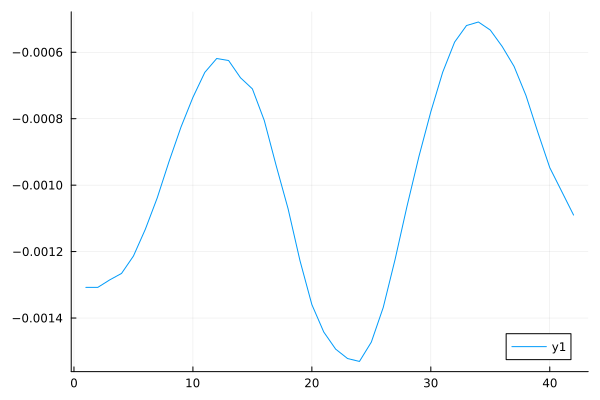

In [979]:
plot(all_Δxtraj[1,41:82])

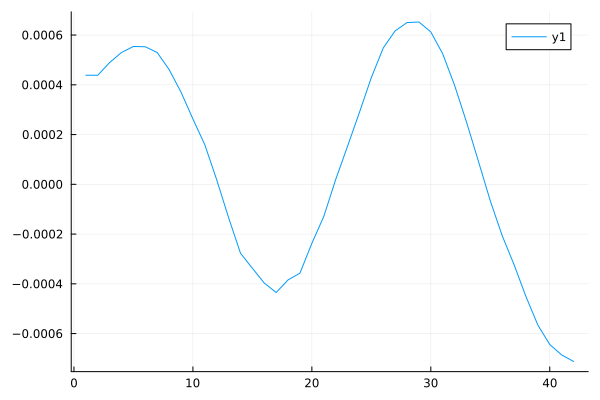

In [980]:
plot(all_Δxtraj[2,41:82])

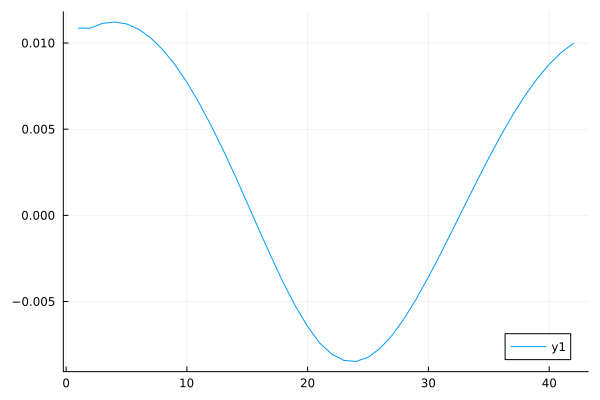

In [981]:
plot(all_Δxtraj[3,41:82])

In [983]:
#the Δt is in SI units (days)

In [985]:
#integrate over the timestep to get the velocity cost in km/day
x_cost = sum(abs.(scaled_control[1,:]))*(Δt)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt)

1.5372908091549358e-11

In [986]:
x_cost

7.471441130581054

In [987]:
25e-3*86400^2*Δt/86400

5.803073603495098

In [988]:
#velocity cost in m/s
#dividing by 86400 to get into seconds bc currently it is in days

#units are good (checked in simulation_test)
x_cost_ms = x_cost*(1e3/86400)
y_cost_ms = y_cost*(1e3/86400)
z_cost_ms = z_cost*(1e3/86400)

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

0.08647501308542886

8.571407782190672e-13

1.7792717698552497e-13

In [989]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms 

0.08647501308646394

In [990]:
cost_per_rev = all_cost/orbit_num

0.0008647501308646394

In [580]:
# #Exclude the first 10 timesteps to fix the injection error
# x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt) *(1e3/86400)
# y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt) *(1e3/86400)
# z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt) *(1e3/86400)

# display(x_cost_good)
# display(y_cost_good)
# display(z_cost_good)

In [581]:
# #cost for 95 revs
# all_cost_good = x_cost_good + y_cost_good + z_cost_good

In [582]:
#final_mpc = reference_trajectory + optimal_x

In [583]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")

In [584]:
#initially
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]],[final_mpc[3,1]], label= "Start Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [585]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label= "Start Point")
#scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]], label= "End Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [586]:
#diff = final_mpc - reference_trajectory

In [587]:
#plot(diff[1,:])
#plot!(diff[2,:])
#plot!(diff[3,:])

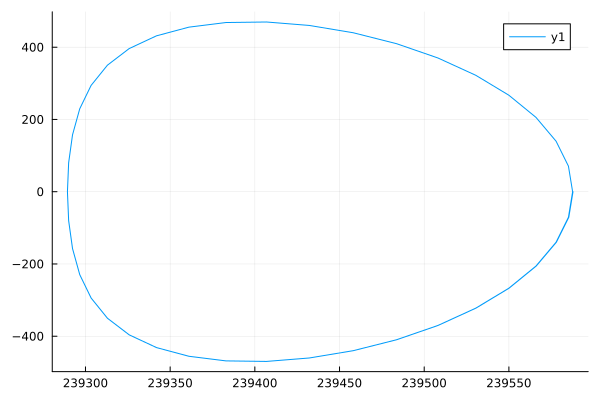

In [588]:
plot(all_xtraj[1,:], all_xtraj[2,:])

In [590]:
all_xtraj[:,end]

6-element Vector{Float64}:
 239587.62671248696
     -0.00024167332646678107
    226.17947343604447
      0.04458310331808881
 -26419.740634162496
      0.03760759640710644

In [591]:
all_optimal_x[:,:,end]

6×21 Matrix{Float64}:
     2.39289e5       2.3929e5  …       2.39585e5       2.39588e5
     0.00104153     80.0764           70.7103         -0.000241673
  -175.735        -172.4             224.151         226.179
    -0.018692      541.095          1829.07            0.0445831
 29978.9         29460.1          -26119.7        -26419.7
    -0.0259026    2469.95      …    1508.14            0.0376076

In [592]:
dot(all_optimal_x[:,end,end], unstable_directions_2[:,21])    

-15895.105176231213

In [593]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
      2.39588e5         2.39585e5  …      2.3929e5      2.39289e5
      2.88578e-15     -70.6931          -80.0777       -0.00345077
    226.168           224.14           -172.369      -175.711
     -5.9486e-9     -1845.23           -541.999        -0.882107
 -26412.9          -26113.2           29459.5       29978.6
     -6.13861e-9    -1508.01       …  -2472.04         -2.49419

[:, :, 2] =
     2.39289e5       2.3929e5  …       2.39585e5       2.39588e5
    -0.00345077     80.0712           70.7101         -0.000264726
  -175.711        -172.38            224.123         226.152
    -0.882107      540.657          1829.0            -0.0603169
 29978.6         29459.9          -26119.7        -26419.7
    -2.49419      2468.66      …    1508.45            0.517435

[:, :, 3] =
      2.39588e5         2.39585e5  …      2.3929e5      2.39289e5
     -0.000264751     -70.7106          -80.0707        0.0043034
    226.152           224.125        

In [594]:
end_state = all_xtraj[:,end]

end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

6×279 Matrix{Float64}:
      2.39588e5         2.39588e5  …       2.44643e5       2.44642e5
     -0.000241673      -0.0539314     -17987.9        -18020.7
    226.179           226.179             -2.03933        -2.92334
      0.0445831        -1.34759       -11889.3        -12131.2
 -26419.7          -26419.7               -3.24648e5      -3.24698e5
      0.0376076        -1.10619    …   -8759.6         -8759.41

In [595]:
#testing
#end_state_sim = reference_trajectory[:,end]

In [596]:
delta_end = end_state - reference_trajectory[:,end]

6-element Vector{Float64}:
 -0.0007228771864902228
 -0.00024169833753992737
  0.011030613540214063
  0.04458792630964412
 -0.005191713233216433
  0.03760840870965994

In [597]:
#end_state_test = reference_trajectory[:,end] - delta_end

In [598]:
#correct_end_state = end_state_test - reference_trajectory[:,end]

In [599]:
#end_state_sim_correct = just_dynamics_integrate(end_state_test, 2.0*sol_t_final[end])


#end_state_traj_correct = get_state(end_state_sim_correct)

In [600]:
deltaaa = xtraj_test[:,1:21] - all_xtraj[:,1:21]

6×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

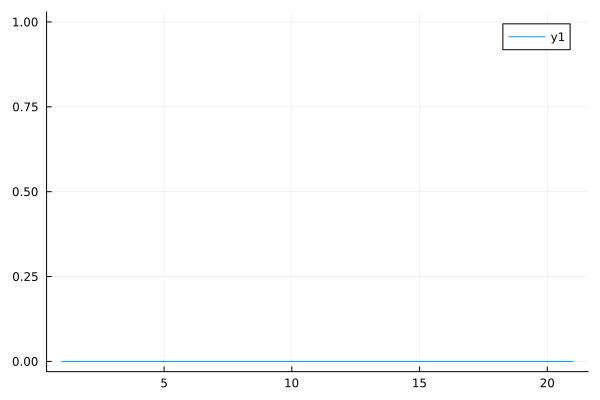

In [601]:
plot(deltaaa[6,:])

In [602]:
half_test = all_xtraj[:,1:21] - reference_trajectory[:,1:21]

6×21 Matrix{Float64}:
 0.238529    0.216882      0.178946    …   0.0103559    0.00789673
 0.0         0.0174786     0.0376542      -0.00244287  -0.00345066
 0.0         5.58429e-5    0.00086992      0.0222193    0.015932
 0.0       -16.1805      -12.1198         -0.936326    -0.882125
 6.84659     6.53644       8.34487        -0.468025    -0.284222
 0.0         0.0301004     0.553922    …  -2.18763     -2.49418

In [603]:
constraint_check_test = zeros(21)
for i=1:21
    constraint_check_test[i] = dot(half_test[:,i], unstable_directions[:,i])

end


In [604]:
constraint_check_test

21-element Vector{Float64}:
  2.9086206060415383
 17.142810383726285
 14.41067609363289
  5.87843288399593
  4.728553693493596
  3.7793472427387798
  3.001223827939575
  2.366048445919721
  1.8496781643999838
  1.4306568967084377
  ⋮
  0.6102166616291003
  0.44051670857343495
  0.3090766599968585
  0.20779258860793293
  0.13660261228679804
  0.08146094595083897
  0.04964232032170862
  0.03232563147605494
  0.03711710802581447

In [605]:
#check the constraint...
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) #> 0 

    end
end

In [606]:
constraint_check[1600:1625]

26-element Vector{Float64}:
 0.10848829360221135
 0.009999136441885999
 0.010222828030819621
 0.011057933558026825
 0.012439854592983697
 0.01431299886490258
 0.016611840772998116
 0.021045489654893508
 0.02499472217798195
 0.027545241335964914
 ⋮
 0.032978608299147345
 0.034450014696599446
 0.03616046166294043
 0.03884441357567267
 0.009997875324313045
 0.009478552903852312
 0.011019735572905753
 0.012716794061620582
 0.014431302790441173

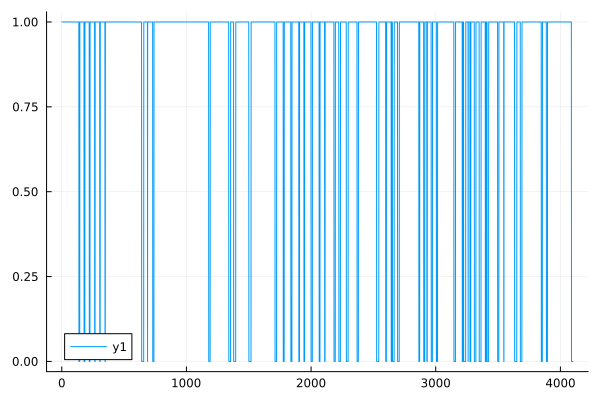

In [607]:
plot(constraint_check.>0)

In [608]:
constraint_check[1:15]

15-element Vector{Float64}:
  2.9086206060415383
 17.142810383726285
 14.41067609363289
  5.87843288399593
  4.728553693493596
  3.7793472427387798
  3.001223827939575
  2.366048445919721
  1.8496781643999838
  1.4306568967084377
  1.0944482417814287
  0.8254061297458247
  0.6102166616291003
  0.44051670857343495
  0.3090766599968585

In [609]:
0.77 * 1e3/86400

0.008912037037037038

In [610]:
constraint_check[50:75]

26-element Vector{Float64}:
 0.00989216229843988
 0.00986854869947576
 0.009841843073609954
 0.009810749160198931
 0.009768177514619905
 0.00972203710574214
 0.00964981280304697
 0.00955701598354513
 0.009431358720917465
 0.00926911891164489
 ⋮
 0.009493018882249349
 0.009804486911078297
 0.0100300495532993
 0.010086433412069865
 0.009899191833161881
 0.009232094276994304
 0.009164970862424623
 0.009503854385573088
 0.010048126166950909

In [611]:
#going to check what happens if I simulate the 4000 controls on the scaled model
all_utraj

3×4000 Matrix{Float64}:
 -7684.19   -1.71725e-7  …  9.14795e-6  3.41304e-6  2.05818e-6
  -526.717  -2.05583e-5     7.8038e-7   5.68756e-7  4.26573e-7
  -225.655  -3.43626e-7     1.81519e-7  1.32909e-7  9.36655e-8

In [612]:
xtraj_test = integrate_oneperiod(all_xtraj[:,1], all_utraj[:,1:40])

6×41 Matrix{Float64}:
      2.39588e5         2.39585e5  …       2.39585e5       2.39588e5
      2.88578e-15     -70.6931            70.7101         -0.000264726
    226.168           224.14             224.123         226.152
     -5.9486e-9     -1845.23            1829.0            -0.0603169
 -26412.9          -26113.2           -26119.7        -26419.7
     -6.13861e-9    -1508.01       …    1508.45            0.517435

In [613]:
Δt/time_scale

0.07711476085647354

In [614]:
norm(xtraj_test[1:3,end]- xtraj_test[1:3,1])/L

9.95955422400351e-7

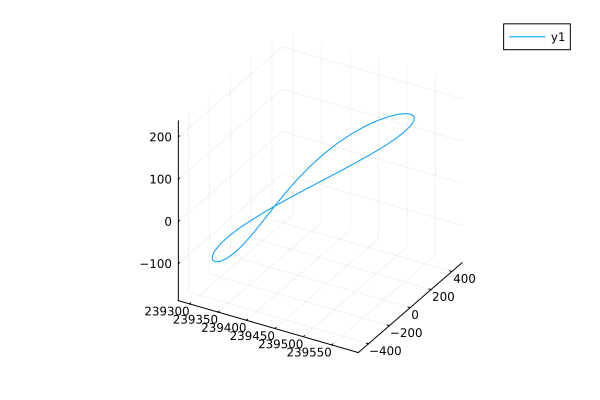

In [615]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [616]:
unstable_directions[:,end]


#for the negative manifold, the final state is satisfying the constraint and that's why it goes to the 
#left 

#however, for the positive manifold, it is satisfying the negative manifold constraint...

6-element Vector{Float64}:
 -0.014154755627771137
  0.0045804331963484905
 -0.0009493005547567748
 -0.8925696587902249
  0.4253207160929784
 -0.14899481206594553

In [617]:
dot(delta_end, unstable_directions[:,end])

-0.04761077745097695

In [618]:
# #check this constraint 
# #works with pi/5 too 

# c_test = unstable_directions[:,end]/tan(pi/6)
# #c_test = unstable_directions[:,end]/tan((pi/2) - deg2rad(60))

# manifold_constraint_test = norm(delta_end) - c_test'*(delta_end)

# manifold_constraint_test
# #push!(cons, manifold_constraint <= 0)

In [619]:
#angle away from the unstable manifold
dot(unstable_directions[:,end], delta_end)*norm(delta_end)*180/pi

-0.16257176404224602

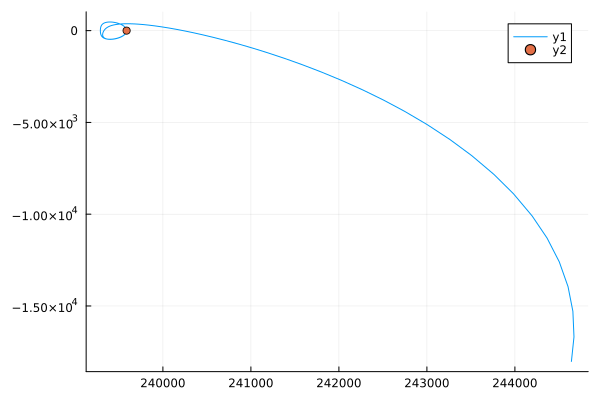

In [620]:
#escapes on the right for positive unstable direction!
plot(end_state_traj[1,:], end_state_traj[2,:])

scatter!([end_state_traj[1,1]], [end_state_traj[2,1]])

In [621]:
#plot(end_state_traj_correct[1,:], end_state_traj_correct[2,:])

#goes to the right when it is in the positive manifold direction. hypothesis is true. however, 
#the solver is giving solutions that does not satisfy this constraint. need to figure out why...

In [ ]:
#needs to be a super small perturbation in order to stay stable

forward_rollout = zeros(6, N_period)

#forward_rollout[:,1] = [1e-3, 0, 0, 0, 1e-6,0]


forward_rollout[:,1] = [1e-9, 0, 0, 0, 1e-9, 0]

for i=1:N_period-1
   
    #diverges with no control 
    #forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i]
    
    #with disturbances it just blows up
    forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i] #+ randn(6)*1e-4
    
end
    

In [ ]:
reference_trajectory

In [ ]:
nocontrol = forward_rollout + reference_trajectory

In [ ]:
plot(nocontrol[1,:], nocontrol[2,:], nocontrol[3,:], lw=3, label="No Control")
plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
scatter!([nocontrol[1,1]], [nocontrol[2,1]], [nocontrol[3,1]], label="No Control Start")
scatter!([nocontrol[1,end]], [nocontrol[2,end]],[nocontrol[3,end]], label="No Control End")

In [ ]:
# plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], lw=3, label="MPC Control")
# plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
# scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label="No Control Start")
# scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]],  label="No Control End", aspectratio = true)

In [ ]:
position_tube_norm = zeros(N_period*orbit_num)

velocity_tube_norm = zeros(N_period*orbit_num)

In [ ]:
orbit_num

In [ ]:
svd(V[:,:,1]).S

In [ ]:
for i=1:N_period*orbit_num
   
    position_tube_norm[i]= norm(all_Δxtraj[1:3,i])
    
    velocity_tube_norm[i]= norm(all_Δxtraj[4:6,i])
    
end

In [ ]:
ctg_constraint = zeros(6, N_period)
dist_from_center = zeros(6, N_period)

In [ ]:
(ones(6).*0.1)./eigen(V[:,:,1]).values

In [ ]:
test_v = (ones(6).*0.1)./eigen(V[:,:,1]).vectors

In [ ]:
test_v * [1,1,1,0,0,0]

In [ ]:
V

In [ ]:
for i= 1:N_period

    e_decomp = eigen(V[:,:,i])

    #inverse same as transpose in this case
    y = inv(e_decomp.vectors) * all_Δxtraj[:,i]

    dist_from_center[:,i] = y

    ctg_constraint[:,i] = sqrt.(1e-3 .*ones(6)./e_decomp.values)


end

    

In [ ]:
ctg_constraint


In [ ]:
dist_from_center

In [ ]:
all_Δxtraj[:,1]'*V[:,:,1]*all_Δxtraj[:,1]

In [ ]:
dist_from_center[1,:]*L

In [ ]:
plot(dist_from_center[1,:], label="x")
plot!(ctg_constraint[1,:], label="x axis constraint")

In [ ]:
plot(dist_from_center[2,:], label="y")
plot!(ctg_constraint[2,:], label="y axis constraint")

In [ ]:
plot(dist_from_center[3,:], label="z")
plot!(ctg_constraint[3,:], label="z axis constraint")

In [ ]:
plot(dist_from_center[4,:], label="vx")
plot!(ctg_constraint[4,:], label="vx axis constraint")

In [ ]:
plot(dist_from_center[5,:], label="vy")
plot!(ctg_constraint[5,:], label="vy axis constraint")

In [ ]:
plot(dist_from_center[6,:], label="vz")
plot!(ctg_constraint[6,:], label="vz axis constraint")

In [ ]:
all_Δxtraj[:,1]

In [ ]:
V[:,:,1]

In [ ]:
#test.vectors*diagm(test.values)*test.vectors'

In [ ]:
#inv(test.vectors)

In [ ]:
#test.vectors'

In [ ]:
# #finding the magnitude of the principle axes of the ellipsoid
# magnitude_principle_axes = zeros(6, N_period)


# for i=1:N_period
    
#     magnitude_principle_axes[:,i] = svd(V[:,:,i]).S
    
    
# end

In [ ]:
# plot(magnitude_principle_axes[1,:])
# plot!(magnitude_principle_axes[2,:])
# plot!(magnitude_principle_axes[3,:])

In [ ]:
# plot(magnitude_principle_axes[4,:])
# plot!(magnitude_principle_axes[5,:])
# plot!(magnitude_principle_axes[6,:])

In [ ]:
plot(all_Δxtraj[1,:])

plot!(all_Δxtraj[2,:])

plot!(all_Δxtraj[3,:])

In [ ]:
plot(all_Δxtraj[4,:])

plot!(all_Δxtraj[5,:])

plot!(all_Δxtraj[6,:])